In [1]:
%load_ext autoreload
%autoreload 2

In [136]:
import sys
sys.path.insert(0, '/home/xhding/workspaces/torch-deep-retina')
import os
import scipy
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import pyret
from kinetic.evaluation import *
from kinetic.utils import *
from kinetic.config import get_custom_cfg
from kinetic.data import *
from kinetic.notebook.functions import *
import kinetic.models as models
from kinetic.models import *
from torchdeepretina.utils import *

In [4]:
device = torch.device('cuda:2')
checkpoint_path = '/home/xhding/saved_model/kinetics_both/epoch_045_loss_-60.15_pearson_natural_0.4562_pearson_noise_0.4354.pth'
checkpoint_path_one_pixel = '/home/xhding/saved_model/kinetics_one_pixel/epoch_005_loss_1.46_pearson_0.4466.pth'
cfg_name = 'kinetics_both'

cfg = get_custom_cfg(cfg_name)
checkpoint = torch.load(checkpoint_path, map_location=device)
model_func = getattr(models, cfg.Model.name)
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
if checkpoint_path_one_pixel != '':
    checkpoint_one_pixel = torch.load(checkpoint_path_one_pixel, map_location=device)
    model.kinetics.ksi.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksi']
    model.kinetics.ksr.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr']
    try:
        if model.ksr_gain:
            model.kinetics.ksr_2.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr_2']
    except:
        pass
model.eval()

data_kwargs = dict(cfg.Data)

In [42]:
model.kinetics.ksr_2.data = torch.tensor([[0]]).to(device)

In [56]:
model.kinetics.ksr_2

Parameter containing:
tensor([[2.4263]], device='cuda:2', requires_grad=True)

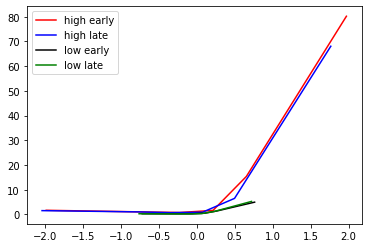

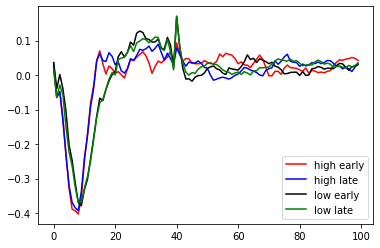

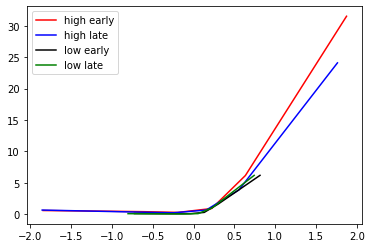

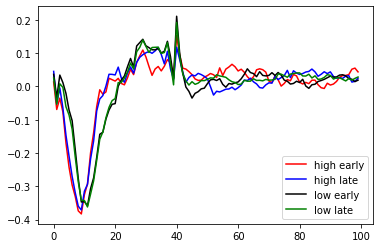

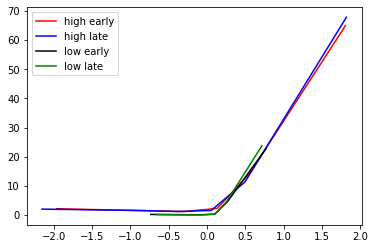

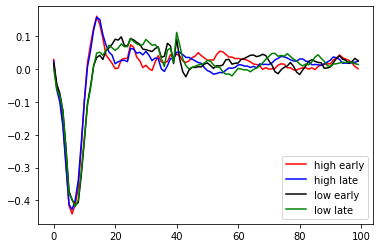

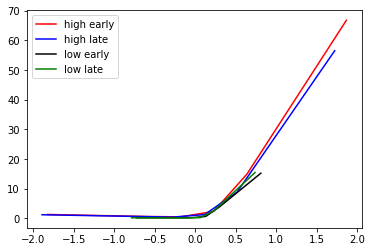

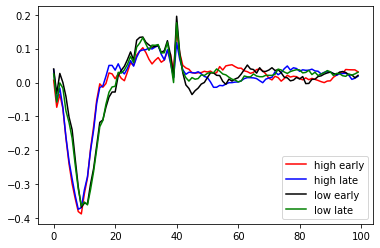

In [58]:
c0=0.2
c1=0.5
nrepeats=30
responses = contrast_adaptation_LN(model, device, c0=c0, c1=c1, nrepeats=nrepeats, **data_kwargs)

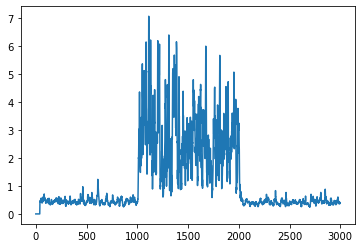

In [59]:
plt.plot(np.array(responses).mean(0)[:,0])

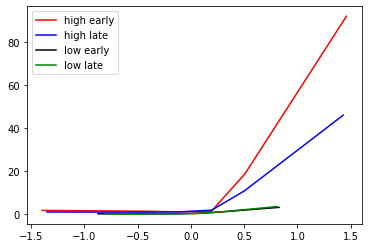

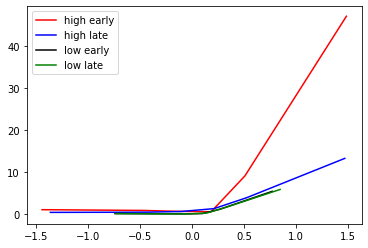

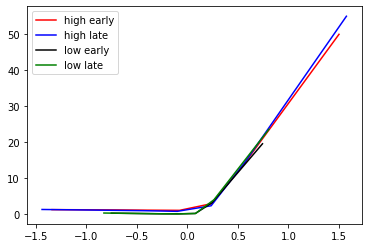

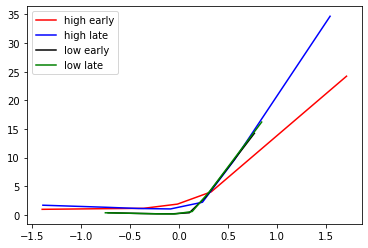

In [21]:
c0=0.2
c1=0.35
nrepeats=100
responses = contrast_adaptation_LN(model, device, c0=c0, c1=c1, nrepeats=nrepeats, **data_kwargs)

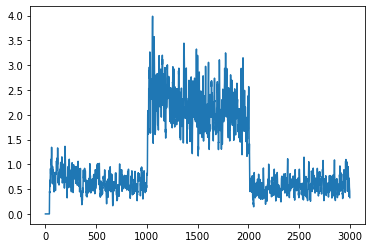

In [27]:
mean_res = np.array(responses).mean(0)
plt.plot(mean_res[:,2])

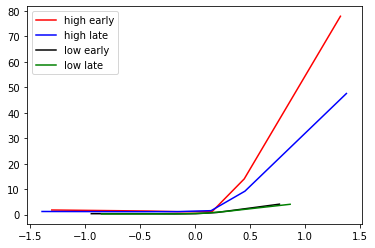

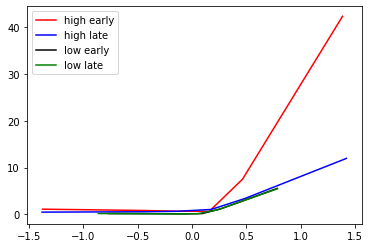

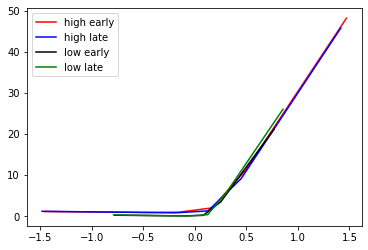

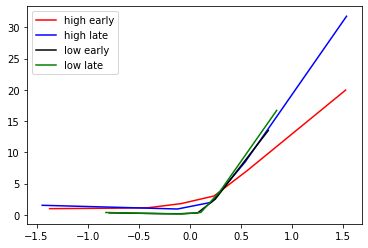

In [25]:
c0=0.2
c1=0.35
nrepeats=100
responses = contrast_adaptation_LN(model, device, c0=c0, c1=c1, nrepeats=nrepeats, **data_kwargs)

In [28]:
data_kwargs = dict(cfg.Data)
train_dataset = TrainDatasetBoth(**data_kwargs)

In [29]:
train_dataset.stats

{'mean': 89.67898235010472, 'std': 43.158659388463775}

In [31]:
data_noise = loadexpt('21-01-26', 'all', 'fullfield_whitenoise', 'train', 40, 0, data_path='/home/xhding/tem_stim')

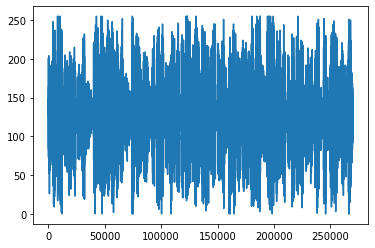

In [35]:
plt.plot(data_noise.X[:,0,0,0])

In [34]:
data_noise.X.shape

(269960, 40, 50, 50)

In [42]:
envelope = stim.flash(1000, 1000, 3000, intensity=(0.35 - 0.05))
envelope += 0.05
x = np.random.randn(*envelope.shape) * envelope

In [50]:
x = (x + 1) * 127.5

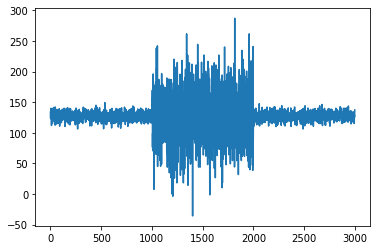

In [51]:
plt.plot(x[:,0,0])

In [52]:
x.std(), x.mean()

(25.923891847193136, 127.40111345943828)

In [25]:
fullfield_dataset = MyDataset('validation', (40,50,50), '/home/xhding/tem_stim', '21-01-26', 'fullfield', 0, cells=[1,2,7,10])

In [26]:
fullfield_dataset.stats

{'mean': 127.65495207667732, 'std': 31.9617540489452}

In [63]:
envelope = np.ones((3000, 50, 50))
envelope[:1000] = c0
envelope[1000:2000] = c1
envelope[2000:] = c0
x = np.random.randn(*envelope.shape) * envelope
x = (x + 1) * 127.5
x = (x - 89.68)/43.16
#x = (x - 127.65)/31.96
#x = (x - x.mean())/x.std()

x = torch.from_numpy(stim.rolling_window(x, 40, time_axis=0)).to(device)

In [64]:
x.shape

torch.Size([2960, 40, 50, 50])

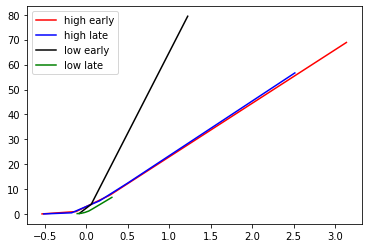

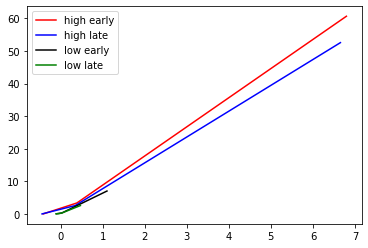

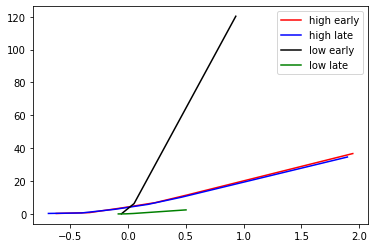

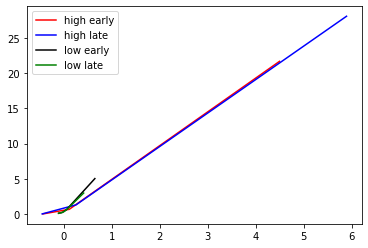

In [125]:
filt_depth = 40
nrepeats = 30
I20=None
cells='all'
duration=1000
delay=1000
nsamples=3000
hs_mode = 'single'
c0 = 0.05
c1 = 0.35

envelope = np.ones((3000, 50, 50))
envelope[:1000] = c0
envelope[1000:2000] = c1
envelope[2000:] = c0

stimuli = []
responses = []
with torch.no_grad():
    for _ in range(nrepeats):
        x = np.random.randn(*envelope.shape) * envelope
        stimuli.append(x)
        x = (x + 1) * 127.5
        #x = (x - 89.68)/43.16
        x = (x - 127.65)/31.96
        #x = (x - x.mean())/x.std()
        
        x = torch.from_numpy(stim.rolling_window(x, filt_depth, time_axis=0)).float().to(device)

        hs = get_hs(model, 1, device, I20, hs_mode)
        layer_outs = inspect_rnn(model, x, hs)
        response = np.pad(layer_outs['outputs'], ((filt_depth, 0), (0,0)), 'constant', constant_values=(0,0))
        responses.append(response)

if cells == 'all':
    cells = range(model.n_units)
for cell in cells:
    sta_he, x_he, nonlinear_he = LN_model_multi_trials2(stimuli, responses, c1, cell, delay, delay + 500, sta_type='revcor')
    sta_hl, x_hl, nonlinear_hl = LN_model_multi_trials2(stimuli, responses, c1, cell, delay + duration - 600, delay + duration, sta_type='revcor')
    sta_le, x_le, nonlinear_le = LN_model_multi_trials2(stimuli, responses, c0, cell, delay + duration, 
                                                     delay + duration + 500, sta_type='revcor')
    sta_ll, x_ll, nonlinear_ll = LN_model_multi_trials2(stimuli, responses, c0, cell, nsamples - 600, nsamples, sta_type='revcor')

    #sta_he, x_he, nonlinear_he = LN_model_multi_trials_fourier(stimuli, responses, c1, cell, delay, delay + 500)
    #sta_hl, x_hl, nonlinear_hl = LN_model_multi_trials_fourier(stimuli, responses, c1, cell, delay + duration - 600, delay + duration)
    #sta_le, x_le, nonlinear_le = LN_model_multi_trials_fourier(stimuli, responses, c0, cell, delay + duration, 
    #                                                      delay + duration + 500)
    #sta_ll, x_ll, nonlinear_ll = LN_model_multi_trials_fourier(stimuli, responses, c0, cell, nsamples - 600, nsamples)
    plt.plot(x_he, nonlinear_he, 'r', label='high early')
    plt.plot(x_hl, nonlinear_hl, 'b', label='high late')
    plt.plot(x_le, nonlinear_le, 'k', label='low early')
    plt.plot(x_ll, nonlinear_ll, 'g', label='low late')
    plt.legend()
    plt.show()

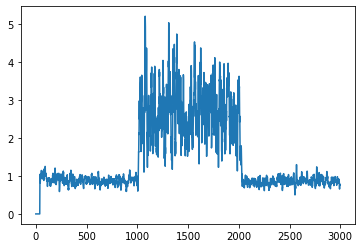

In [126]:
plt.plot(np.array(responses).mean(0)[:,0])

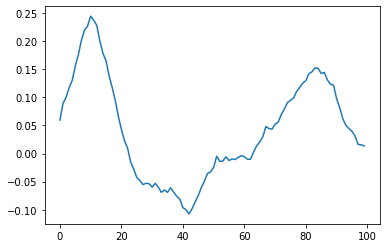

In [127]:
spatial, temporal = ft.decompose(sta_he)
plt.plot(temporal)

In [120]:
sta_he.mean()

5.3707038816241944e-21

In [82]:
stimuli[0].shape

(3000, 50, 50)

In [87]:
responses[0].shape

(3000, 4)

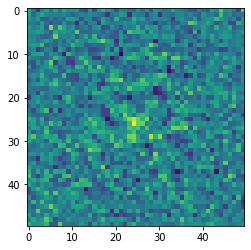

In [104]:
plt.imshow(spatial)

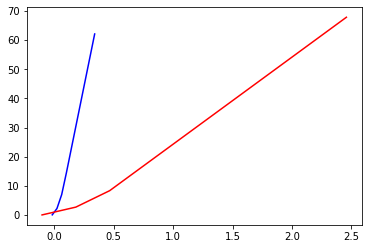

In [146]:
filt_depth = 40
nrepeats = 30
I20=None
cells='all'
hs_mode = 'single'
contrast = 0.05
filter_len = 100

cell = 0
with torch.no_grad():
    for contrast in [0.05, 0.35]:
        x = np.random.randn(1347,50,50) * contrast
        x = np.repeat(x, 3, axis=0)
        stimulus = x
        #x = (x + 1) * 127.5
        #x = (x - 89.68)/43.16
        #x = (x - 127.65)/31.96
        x = 2.37 * x

        x = torch.from_numpy(stim.rolling_window(x, filt_depth, time_axis=0)).float().to(device)

        hs = get_hs(model, 1, device, I20, hs_mode)
        layer_outs = inspect_rnn(model, x, hs)
        responses = np.pad(layer_outs['outputs'], ((filt_depth, 0), (0,0)), 'constant', constant_values=(0,0))


        resp = responses[:, cell]
        sta, _ = pyret.filtertools.revcorr(stimulus, scipy.stats.zscore(resp), 0, filter_len)
        #sta, _ = pyret.filtertools.revcorr(stimulus, resp, 0, filter_len)
        sta = np.flip(sta, axis=0)
        sta -= sta.mean()

        #normed_sta, _, _= normalize_filter(sta, stimulus, contrast)
        normed_sta = normalize_filter2(sta, stimulus)

        filtered_stim = pyret.filtertools.linear_response(normed_sta, stimulus)
        nonlinearity = Binterp(10)
        #nonlinearity = Sigmoid(peak=100.)
        nonlinearity.fit(filtered_stim[filter_len:], resp[filter_len:])

        x = np.linspace(np.min(filtered_stim), np.max(filtered_stim), 10)
        nonlinear_prediction = nonlinearity.predict(x)
        spatial, temporal = ft.decompose(normed_sta)

        if contrast == 0.05:
            plt.plot(x, nonlinear_prediction, 'b-')
        else:
            plt.plot(x, nonlinear_prediction, 'r-')
    plt.show()

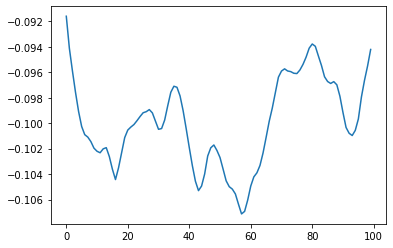

In [147]:
spatial, temporal = ft.decompose(normed_sta)
plt.plot(temporal)

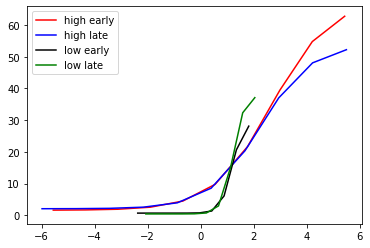

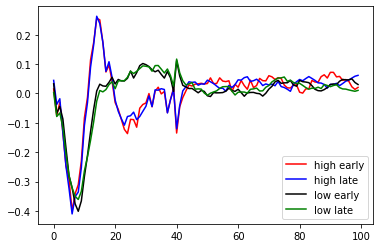

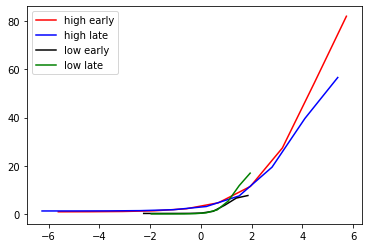

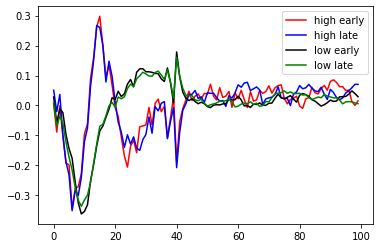

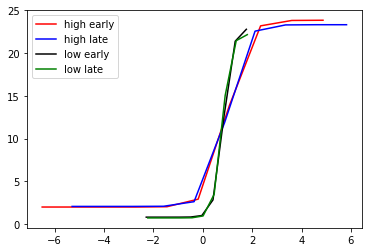

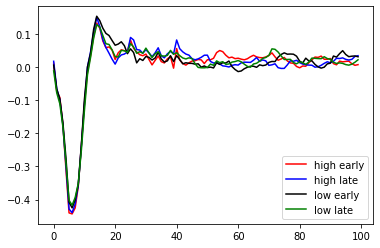

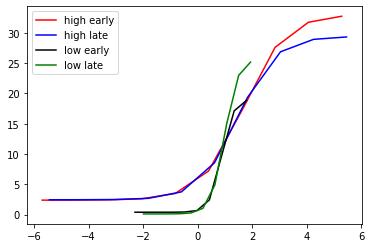

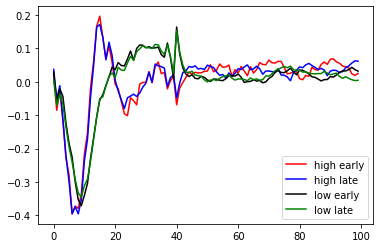

In [90]:
c0=0.5
c1=1.5
nrepeats=30
responses = contrast_adaptation_LN(model, device, c0=c0, c1=c1, nrepeats=nrepeats, **data_kwargs)

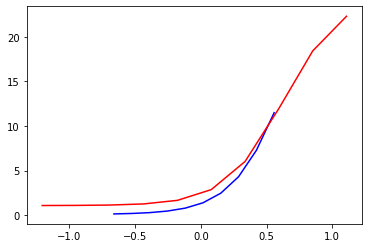

In [16]:
filt_depth = 40
I20=None
cells='all'
hs_mode = 'single'

cell = 0
for contrast in [0.2, 0.35]:
    x = np.random.randn(1347,50,50) * contrast
    x = np.repeat(x, 3, axis=0)
    stimulus = x
    x = 2.95 * x

    x = torch.from_numpy(stim.rolling_window(x, filt_depth, time_axis=0)).float().to(device)

    hs = get_hs(model, 1, device, I20, hs_mode)
    layer_outs = inspect_rnn(model, x, hs)
    responses = np.pad(layer_outs['outputs'], ((filt_depth, 0), (0,0)), 'constant', constant_values=(0,0))


    resp = responses[:, cell]
    sta = compute_sta_rnn(model, contrast, layer='ganglion', cell_index=cell, verbose=False)
    sta = np.flip(sta, axis=0)
    sta -= sta.mean()

    #normed_sta, _, _= normalize_filter(sta, stimulus, contrast)
    normed_sta = normalize_filter2(sta, stimulus)

    filtered_stim = pyret.filtertools.linear_response(normed_sta, stimulus)
    #nonlinearity = Binterp(10)
    nonlinearity = Sigmoid(peak=100.)
    nonlinearity.fit(filtered_stim[filt_depth:], resp[filt_depth:], maxfev=5000)

    x = np.linspace(np.min(filtered_stim), np.max(filtered_stim), 10)
    nonlinear_prediction = nonlinearity.predict(x)
    spatial, temporal = ft.decompose(normed_sta)

    if contrast == 0.2:
        plt.plot(x, nonlinear_prediction, 'b-')
    else:
        plt.plot(x, nonlinear_prediction, 'r-')
plt.show()

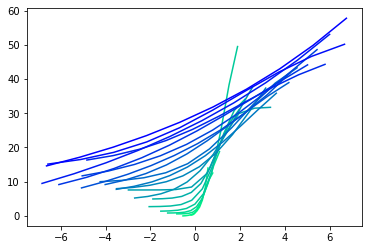

In [22]:
filt_depth = 40
I20=None
cells='all'
hs_mode = 'single'
cell = 0

cmap = plt.cm.get_cmap('winter')
colors = cmap(np.linspace(0, 1, 20))[::-1]

for idx, contrast in enumerate(np.linspace(0.05, 2., 20)):
    x = np.random.randn(1347,50,50) * contrast
    x = np.repeat(x, 3, axis=0)
    stimulus = x
    x = 2.95 * x

    x = torch.from_numpy(stim.rolling_window(x, filt_depth, time_axis=0)).float().to(device)

    hs = get_hs(model, 1, device, I20, hs_mode)
    layer_outs = inspect_rnn(model, x, hs)
    responses = np.pad(layer_outs['outputs'], ((filt_depth, 0), (0,0)), 'constant', constant_values=(0,0))


    resp = responses[:, cell]
    sta = compute_sta_rnn(model, contrast, layer='ganglion', cell_index=cell, verbose=False)
    sta = np.flip(sta, axis=0)
    sta -= sta.mean()

    #normed_sta, _, _= normalize_filter(sta, stimulus, contrast)
    normed_sta = normalize_filter2(sta, stimulus)

    filtered_stim = pyret.filtertools.linear_response(normed_sta, stimulus)
    #nonlinearity = Binterp(10)
    nonlinearity = Sigmoid(peak=100.)
    try:
        nonlinearity.fit(filtered_stim[filt_depth:], resp[filt_depth:], maxfev=5000)

        x = np.linspace(np.min(filtered_stim), np.max(filtered_stim), 10)
        nonlinear_prediction = nonlinearity.predict(x)
        spatial, temporal = ft.decompose(normed_sta)

        plt.plot(x, nonlinear_prediction, color=colors[idx])
    except:
        pass
plt.show()

In [60]:
filt_depth = 40
nrepeats = 10
I20=None
hs_mode = 'single'
cell = 0
c0 = 0.15
c1 = 0.35

envelope = np.ones((3040, 50, 50))
envelope[:1040] = c0
envelope[1040:2040] = c1
envelope[2040:] = c0

data_list = []
for _ in range(nrepeats):
    x = np.random.randn(*envelope.shape) * envelope
    stimulus = x
    x = 2.95 * x + 0.88

    x = torch.from_numpy(stim.rolling_window(x, filt_depth, time_axis=0)).float().to(device)

    hs = get_hs(model, 1, device, I20, hs_mode)
    grad, output = inspect_grad_rnn(model, x, hs, cell_idx=cell)
    segment_dict = later_early_segments(stimulus, grad, output)
    data_list.append(segment_dict)
    
filters = gradient_filter(data_list)
nonlinear = nonlinearities(data_list, filters)

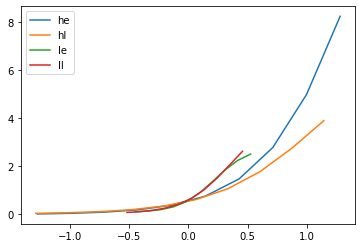

In [61]:
for key in nonlinear.keys():
    x, nonlinear_prediction = nonlinear[key]
    plt.plot(x, nonlinear_prediction, label=key)
plt.legend()
plt.show()

In [80]:
filt_depth = 40
nrepeats = 10
I20=None
hs_mode = 'single'
cell = 0
c0 = 0.5
c1 = 1.2

envelope = np.ones((3040, 1, 1))
envelope[:1040] = c0
envelope[1040:2040] = c1
envelope[2040:] = c0

data_list = []
for _ in range(nrepeats):
    x = np.random.randn(*envelope.shape) * envelope
    x = x * np.ones((envelope.shape[0], 50, 50))
    stimulus = x
    x = 2.95 * x

    x = torch.from_numpy(stim.rolling_window(x, filt_depth, time_axis=0)).float().to(device)

    hs = get_hs(model, 1, device, I20, hs_mode)
    grad, output = inspect_grad_rnn(model, x, hs, cell_idx=cell)
    segment_dict = later_early_segments(stimulus, grad, output)
    data_list.append(segment_dict)
    
filters = gradient_filter(data_list, True)
nonlinear = nonlinearities(data_list, filters)

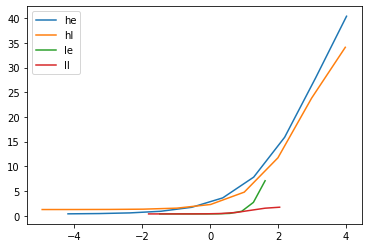

In [81]:
for key in nonlinear.keys():
    x, nonlinear_prediction = nonlinear[key]
    plt.plot(x, nonlinear_prediction, label=key)
plt.legend()
plt.show()

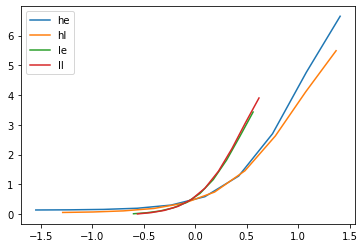

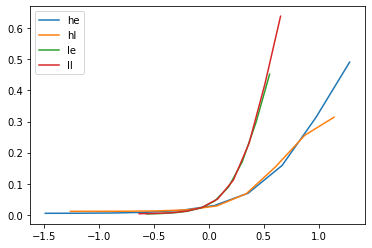

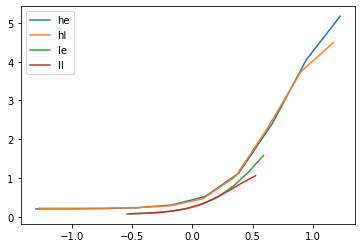

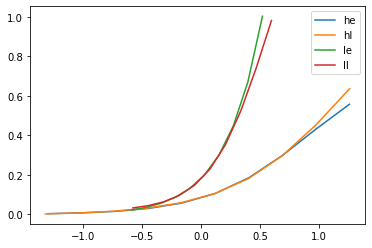

In [86]:
for cell in range(4):
    filters, nonlinear = gradient_LN(model, device, cell = cell, c0 = 0.15, c1 = 0.35, scale=2.95, shift=0.88, stim_type='checkerboard', nrepeats=30)

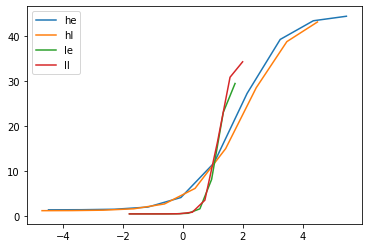

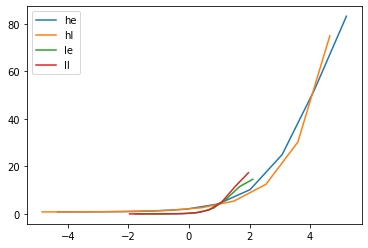

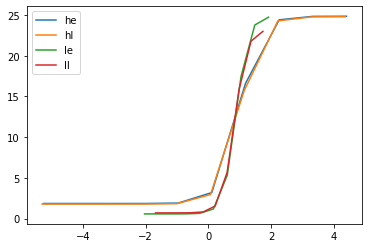

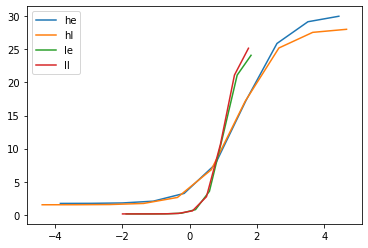

In [87]:
for cell in range(4):
    filters, nonlinear = gradient_LN(model, device, cell = cell, c0 = 0.5, c1 = 1.2, scale=2.95, shift=0., stim_type='fullfield', nrepeats=30)

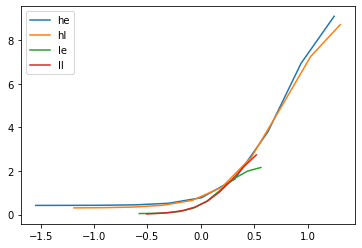

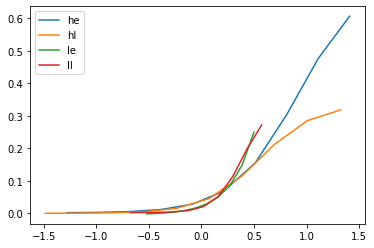

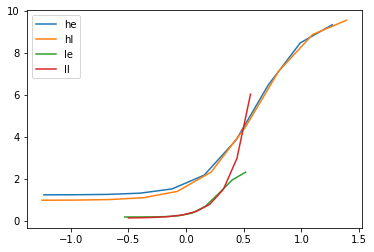

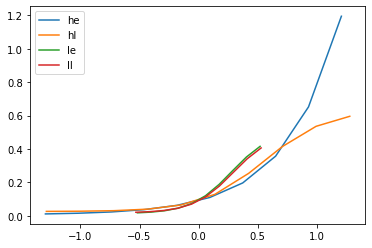

In [94]:
for cell in range(4):
    filters, nonlinear = gradient_LN(model, device, cell = cell, c0 = 0.15, c1 = 0.35, scale=2.95, shift=0.88, stim_type='checkerboard', nrepeats=30)

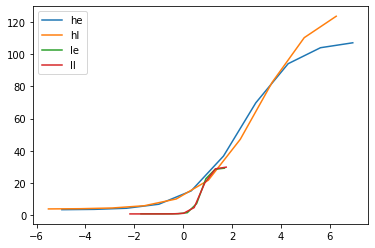

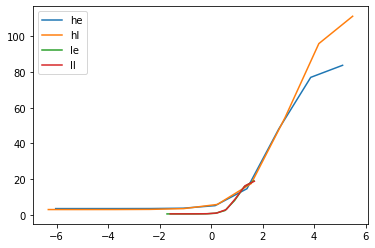

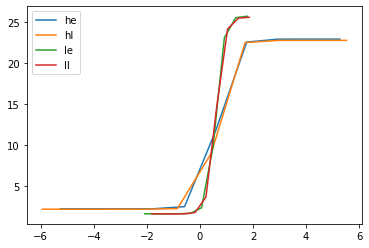

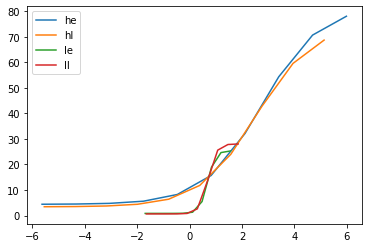

In [95]:
for cell in range(4):
    filters, nonlinear = gradient_LN(model, device, cell = cell, c0 = 0.5, c1 = 1.5, scale=2.95, shift=0., stim_type='fullfield', nrepeats=30)

In [19]:
device = torch.device('cuda:2')
checkpoint_path = '/home/xhding/saved_model/kinetics_both/epoch_045_loss_-60.35_pearson_natural_0.4354_pearson_noise_0.4798.pth'
#checkpoint_path_one_pixel = '/home/xhding/saved_model/kinetics_one_pixel/epoch_008_loss_1.43_pearson_0.4901.pth'
checkpoint_path_one_pixel = '/home/xhding/saved_model/kinetics_one_pixel/epoch_005_loss_1.43_pearson_0.4919.pth'
cfg_name = 'kinetics_both'

cfg = get_custom_cfg(cfg_name)
checkpoint = torch.load(checkpoint_path, map_location=device)
model_func = getattr(models, cfg.Model.name)
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
if checkpoint_path_one_pixel != '':
    checkpoint_one_pixel = torch.load(checkpoint_path_one_pixel, map_location=device)
    model.kinetics.ksi.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksi']
    model.kinetics.ksr.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr']
    try:
        if model.ksr_gain:
            model.kinetics.ksr_2.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr_2']
    except:
        pass
model.eval()

data_kwargs = dict(cfg.Data)

In [4]:
fullfield_dataset = MyDataset('train', (40,50,50), '/home/xhding/tem_stim', '21-01-26', 'fullfield', 0, cells=[1,2,7,10])
fullfield_dataset.stats

{'mean': 127.65495207667732, 'std': 31.9617540489452}

In [31]:
fullfield_dataset = MyDataset('train', (40,50,50), '/home/xhding/tem_stim', '21-01-26', 'fullfield_whitenoise', 30000, cells='all')
fullfield_dataset.stats

{'mean': 127.54951851851852, 'std': 28.607890356944278}

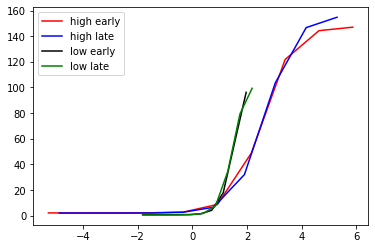

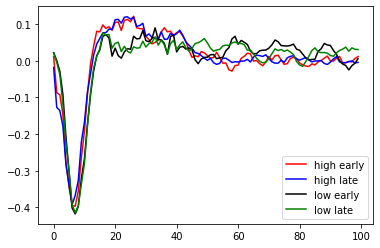

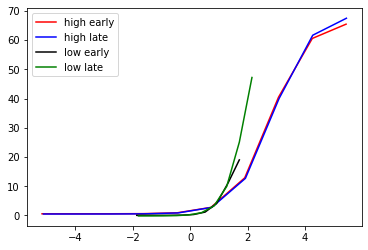

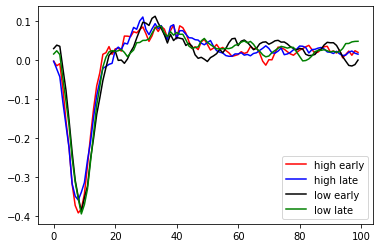

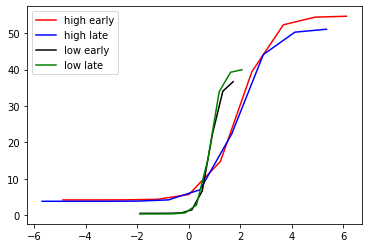

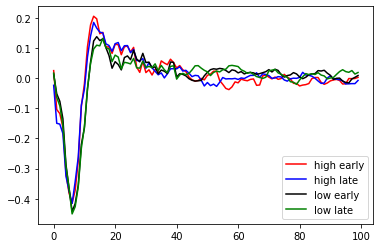

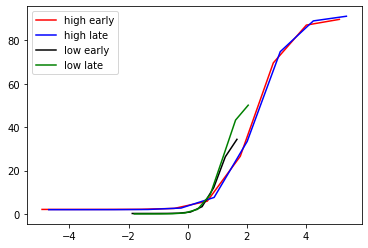

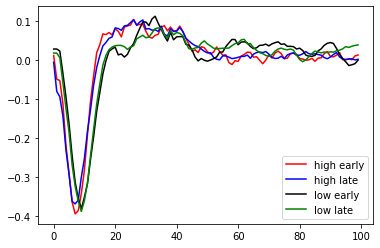

In [12]:
c0=0.5
c1=1.5
nrepeats=30
responses = contrast_adaptation_LN(model, device, c0=c0, c1=c1, nrepeats=nrepeats, scale=4.46, **data_kwargs)

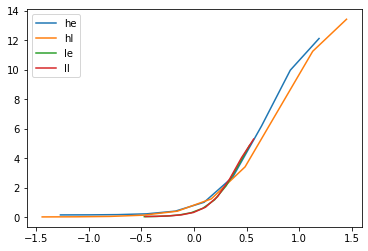

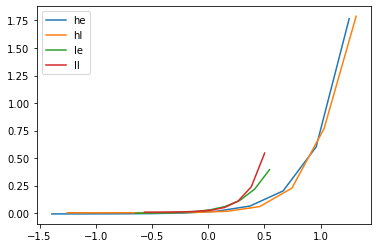

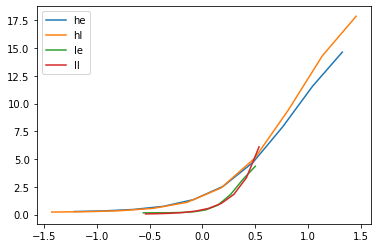

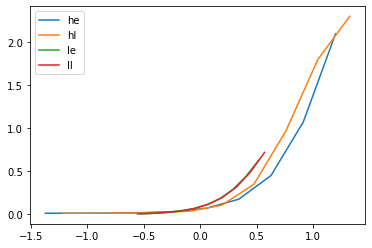

In [20]:
for cell in range(4):
    filters, nonlinear = gradient_LN(model, device, cell = cell, c0 = 0.15, c1 = 0.35, scale=3.99, shift=0., fpf=1, stim_type='checkerboard', nrepeats=10)

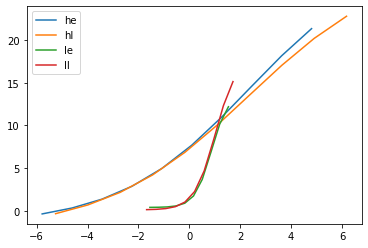

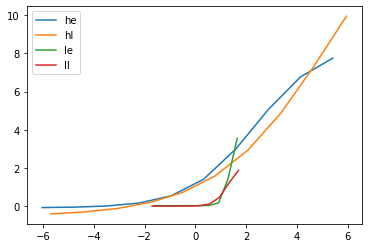

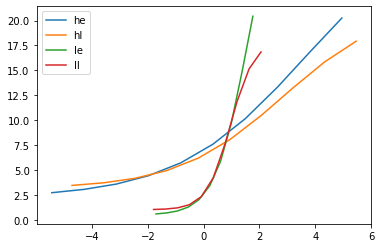

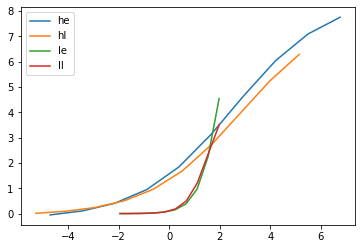

In [23]:
for cell in range(4):
    filters, nonlinear = gradient_LN(model, device, cell = cell, c0 = 0.5, c1 = 1.5, scale=3.99, shift=0., fpf=1, stim_type='checkerboard', nrepeats=10)

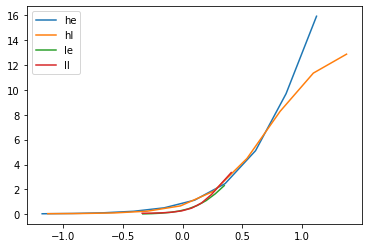

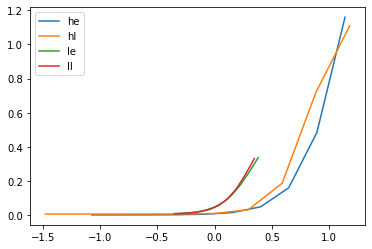

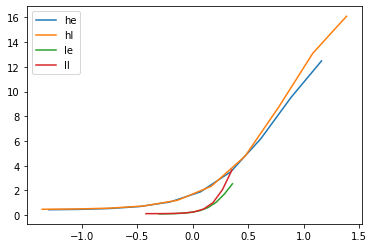

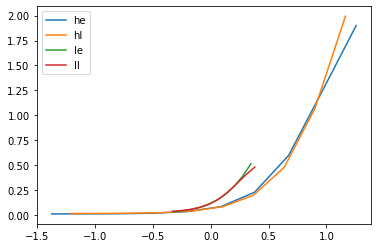

In [24]:
for cell in range(4):
    filters, nonlinear = gradient_LN(model, device, cell = cell, c0 = 0.1, c1 = 0.35, scale=3.99, shift=0., fpf=1, stim_type='checkerboard', nrepeats=10)

In [338]:
device = torch.device('cuda:2')
checkpoint_path = '/home/xhding/saved_model/kinetics_both/epoch_045_loss_-60.35_pearson_natural_0.4354_pearson_noise_0.4798.pth'
#checkpoint_path_one_pixel = '/home/xhding/saved_model/kinetics_one_pixel/epoch_008_loss_1.43_pearson_0.4901.pth'
checkpoint_path_one_pixel = '/home/xhding/saved_model/kinetics_one_pixel/epoch_028_loss_1.43_pearson_0.4880.pth'
cfg_name = 'kinetics_both'

cfg = get_custom_cfg(cfg_name)
checkpoint = torch.load(checkpoint_path, map_location=device)
model_func = getattr(models, cfg.Model.name)
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
if checkpoint_path_one_pixel != '':
    checkpoint_one_pixel = torch.load(checkpoint_path_one_pixel, map_location=device)
    model.kinetics.ksi.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksi']
    model.kinetics.ksr.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr']
    try:
        if model.ksr_gain:
            model.kinetics.ksr_2.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr_2']
    except:
        pass
model.eval()

data_kwargs = dict(cfg.Data)

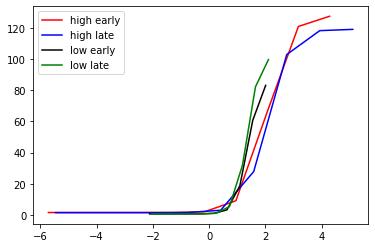

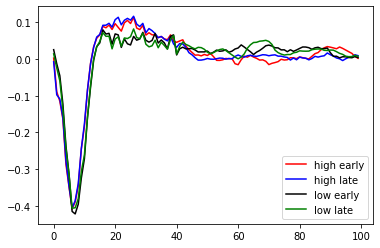

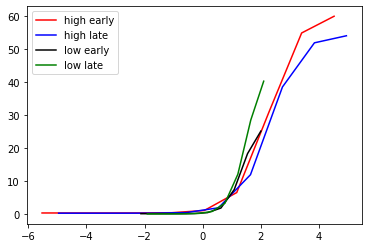

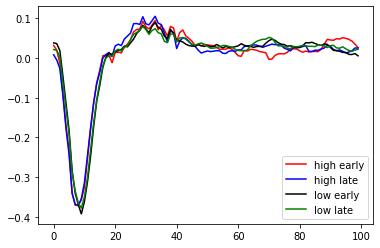

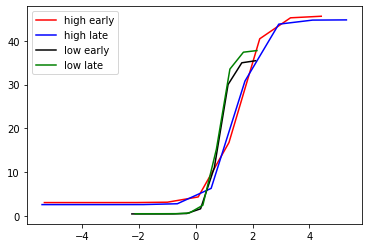

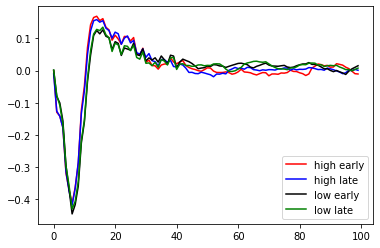

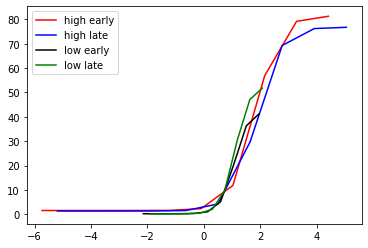

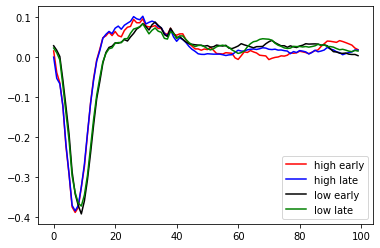

In [33]:
c0=0.5
c1=1.2
nrepeats=100
responses = contrast_adaptation_LN(model, device, c0=c0, c1=c1, nrepeats=nrepeats, scale=4.46, **data_kwargs)

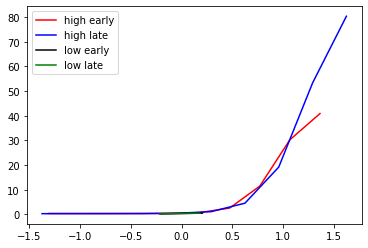

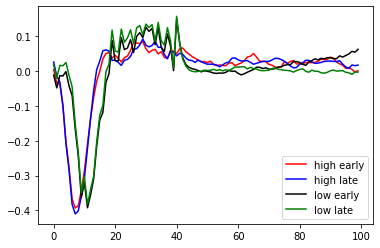

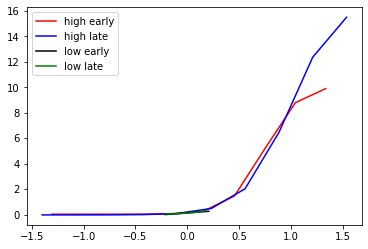

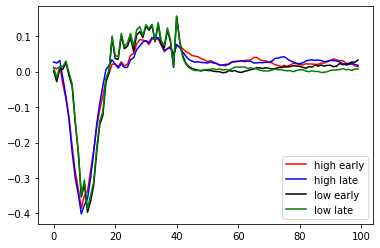

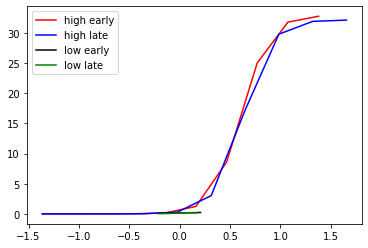

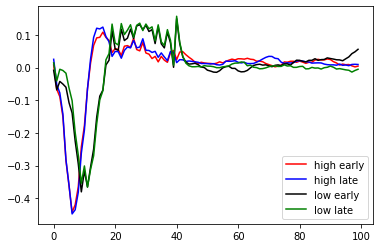

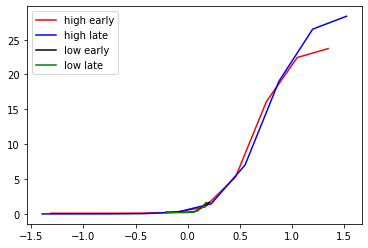

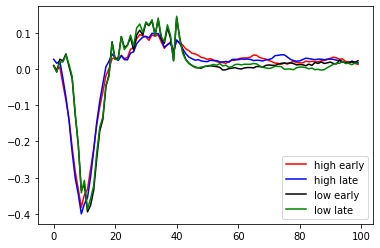

In [35]:
c0=0.05
c1=0.35
nrepeats=100
responses = contrast_adaptation_LN(model, device, c0=c0, c1=c1, nrepeats=nrepeats, scale=4.46, **data_kwargs)

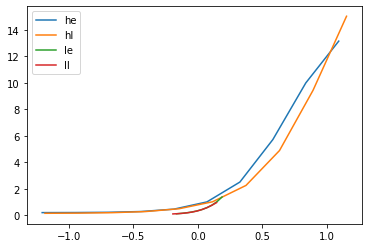

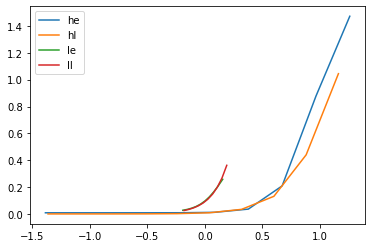

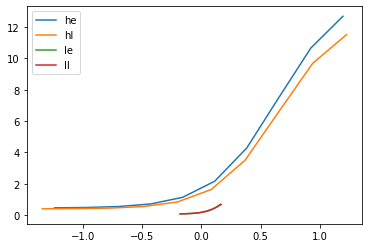

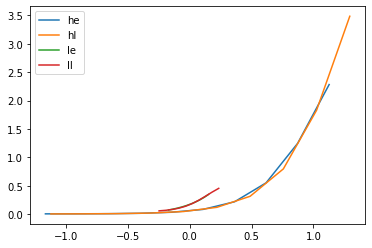

In [34]:
for cell in range(4):
    filters, nonlinear = gradient_LN(model, device, cell = cell, c0 = 0.05, c1 = 0.35, scale=4.46, shift=0., fpf=1, stim_type='checkerboard', nrepeats=10)

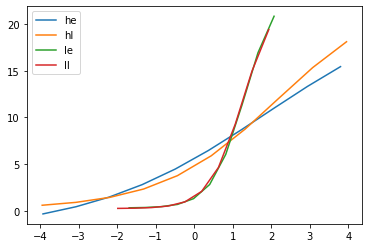

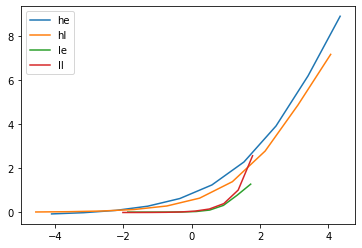

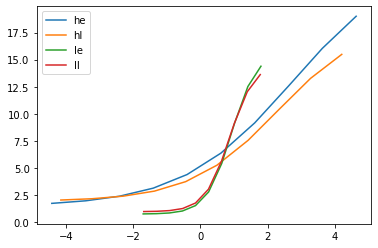

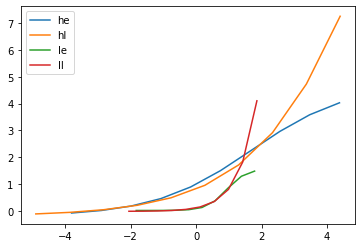

In [5]:
for cell in range(4):
    filters, nonlinear = gradient_LN(model, device, cell = cell, c0 = 0.5, c1 = 1.2, scale=4.46, shift=0., fpf=1, stim_type='checkerboard', nrepeats=10)

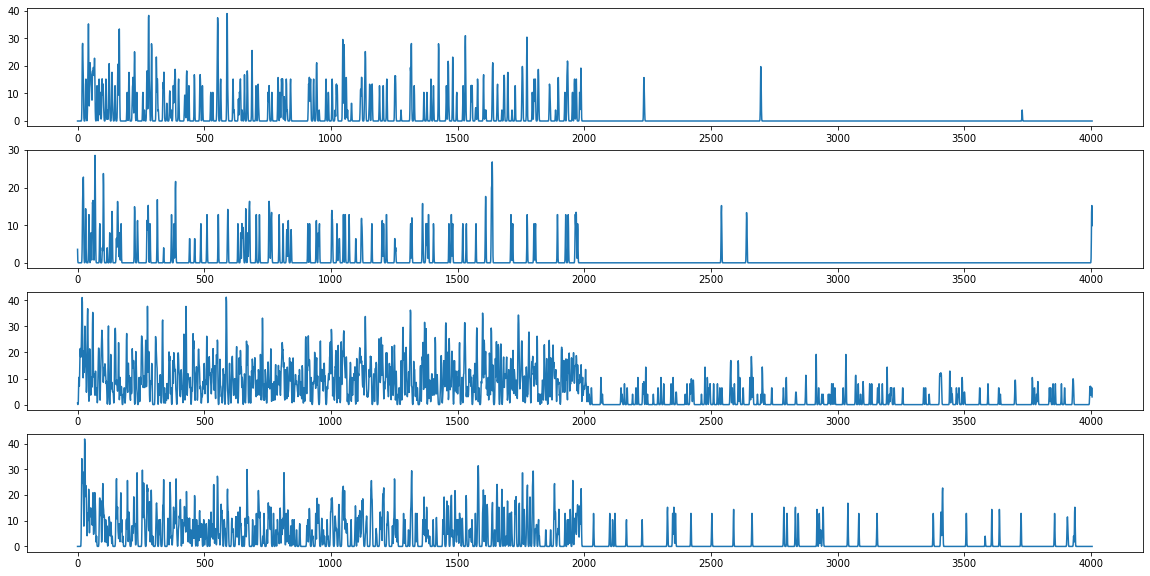

In [6]:
with h5py.File('/home/xhding/tem_stim/21-01-26/fullfield.h5', 'r') as f:
    stimulus =  np.asarray(f['train']['stimulus'][:, 25, 25]).astype('float32')
    resp = np.asarray(f['train']['response']['firing_rate_10ms'])
stimuli = stimulus[:40060].reshape((10,-1))
responses = np.swapaxes(resp, 0, 1)[:40060].reshape((10, -1, 11))
fig,ax = plt.subplots(4,1,figsize=(20,10))
for i, cell in enumerate([1,2,7,10]):
    ax[i].plot(responses.mean(0)[:, cell])
plt.show()

In [406]:
stats = {'mean': 127.54951851851852, 'std': 28.607890356944278}
fullfield_dataset = MyDataset('validation', (40,50,50), '/home/xhding/tem_stim', '21-01-26', 'fullfield', 0, stats=stats, cells=[1,2,7,10])
fullfield_data =  DataLoader(fullfield_dataset)
pearson, val_pred, val_targ = pearsonr_eval(model, fullfield_data, 4, device, with_responses=True)

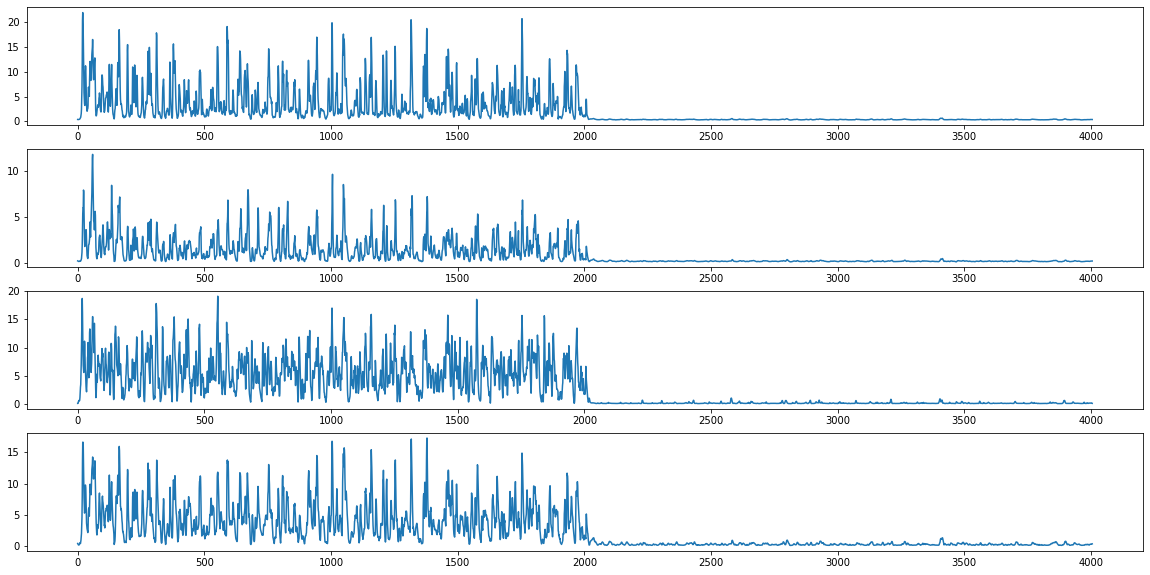

In [13]:
responses = val_pred[3966:40020, :].reshape((9, -1, 4))
fig,ax = plt.subplots(4,1,figsize=(20,10))
for i in range(4):
    ax[i].plot(responses.mean(0)[:, i])
plt.show()

In [12]:
pearson

0.5317367463596985

In [16]:
((val_pred - val_targ)**2).mean()

159.87417833040823

In [33]:
((1.2*val_pred - val_targ)**2).mean()

157.81463201071438

In [43]:
(1.42*val_pred - val_targ).mean()

4.4309820541389784e-05

In [58]:
np.abs(0*val_pred - val_targ).mean()

3.058164845516696

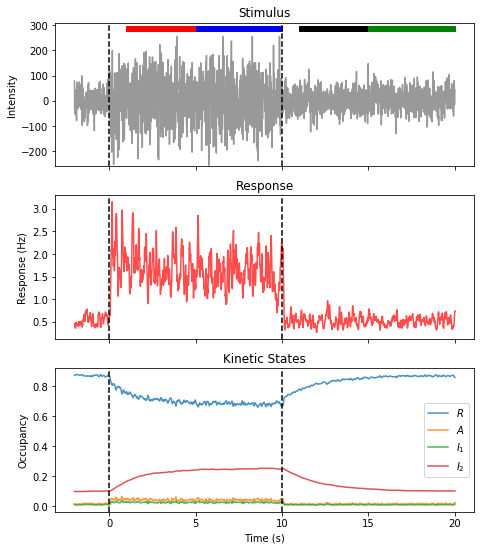

In [226]:
fig, axes = plt.subplots(3,1, figsize=(7.5,9), sharex=True)
for trial in range(len(stimuli)):
    stimuli[trial][stimuli[trial]>1.] = 1.
    stimuli[trial][stimuli[trial]<-1.] = -1.
axes[0].plot(np.linspace(-2, 20, 2200), 255*stimuli[0][800:], color='gray', alpha=0.8)
axes[0].axvline(x=0, color='black', ls='--')
axes[0].axvline(x=10, color='black', ls='--')
axes[0].set_ylabel('Intensity')
axes[0].set_title('Stimulus')
axes[0].set_ylim((-260, 310))
axes[0].add_patch(patches.Rectangle((1, 275), 4, 20, color='red'))
axes[0].add_patch(patches.Rectangle((5, 275), 5, 20, color='blue'))
axes[0].add_patch(patches.Rectangle((11, 275), 4, 20, color='black'))
axes[0].add_patch(patches.Rectangle((15, 275), 5, 20, color='green'))

axes[1].plot(np.linspace(-2, 20, 2200), np.array(responses).mean(0)[800:, 3], color='r', alpha=0.7)
axes[1].axvline(x=0, color='black', ls='--')
axes[1].axvline(x=10, color='black', ls='--')
axes[1].set_ylabel('Response (Hz)')
axes[1].set_title('Response')

channel = 1
axes[2].plot(np.linspace(-2, 20, 2200),layer_outs['kinetics'][760:, 0, channel], label=r'$R$', alpha=0.8)
axes[2].plot(np.linspace(-2, 20, 2200),layer_outs['kinetics'][760:, 1, channel], label=r'$A$', alpha=0.8)
axes[2].plot(np.linspace(-2, 20, 2200),layer_outs['kinetics'][760:, 2, channel], label=r'$I_1$', alpha=0.8)
axes[2].plot(np.linspace(-2, 20, 2200),layer_outs['kinetics'][760:, 3, channel], label=r'$I_2$', alpha=0.8)
axes[2].legend()
axes[2].axvline(x=0, color='black', ls='--')
axes[2].axvline(x=10, color='black', ls='--')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Occupancy')
axes[2].set_title('Kinetic States')

plt.savefig('/home/xhding/workspaces/torch-deep-retina/kinetic/notebook/figures/response.png', dpi=300,  bbox_inches = "tight")

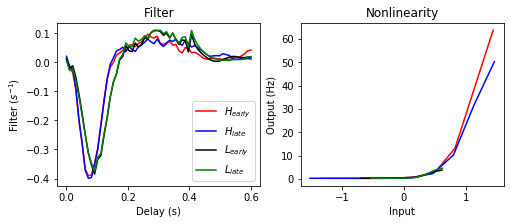

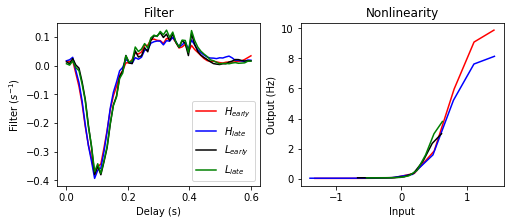

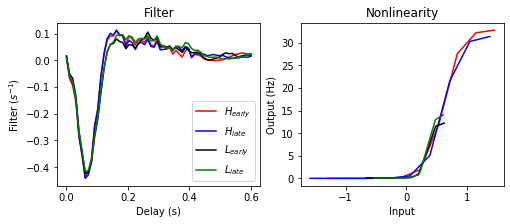

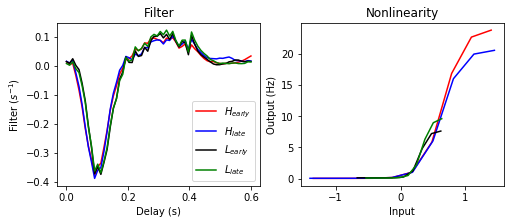

In [177]:
c0=0.15
c1=0.35
nrepeats=100
stimuli, responses = contrast_adaptation_LN(model, device, c0=c0, c1=c1, nrepeats=nrepeats, scale=4.46, fpf=1, **data_kwargs)

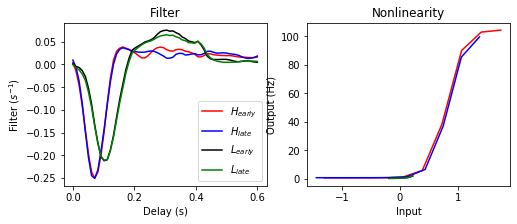

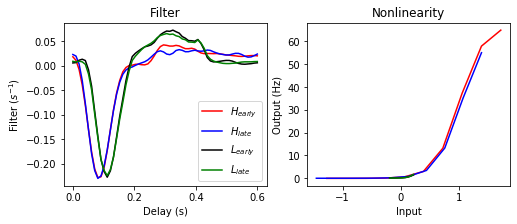

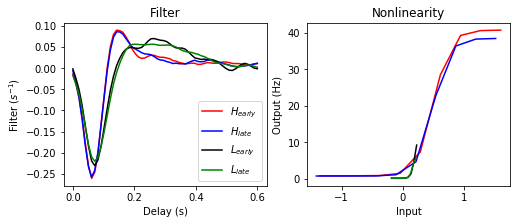

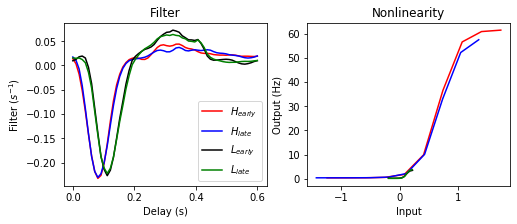

In [340]:
c0=0.05
c1=0.35
nrepeats=100
stimuli, responses = contrast_adaptation_LN(model, device, c0=c0, c1=c1, nrepeats=nrepeats, scale=4.46, fpf=3, **data_kwargs)

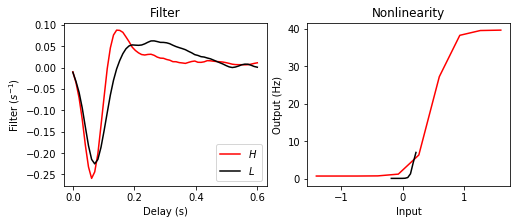

In [343]:
sta_h, x_h, nonlinear_h = LN_model_multi_trials(stimuli, responses, contrast=0.35, cell=2, start_idx=1000, end_idx=2000, filter_len=100, sta_type='revcor')
sta_l, x_l, nonlinear_l = LN_model_multi_trials(stimuli, responses, contrast=0.05, cell=2, start_idx=2000, end_idx=3000, filter_len=100, sta_type='revcor')

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].plot(np.linspace(0, 0.6, 60), sta_h[:60], 'r', label=r'$H$')
axes[0].plot(np.linspace(0, 0.6, 60), sta_l[:60], 'k', label=r'$L$')
axes[0].legend()
axes[0].set_xlabel('Delay (s)')
axes[0].set_ylabel(r'Filter ($s^{-1}$)')
axes[0].set_title('Filter')


axes[1].plot(x_h, nonlinear_h, 'r', label=r'$H$')
axes[1].plot(x_l, nonlinear_l, 'k', label=r'$L$')
axes[1].set_xlabel('Input')
axes[1].set_ylabel('Output (Hz)')
axes[1].set_title('Nonlinearity')

plt.show()

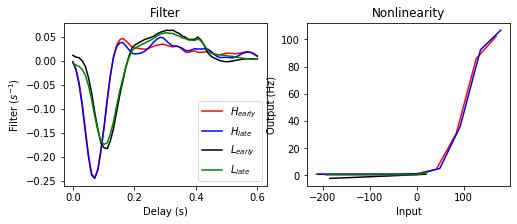

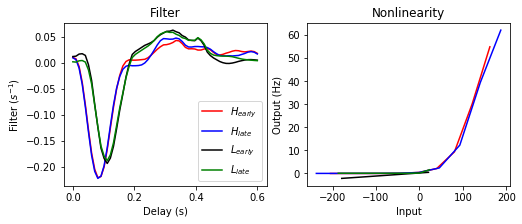

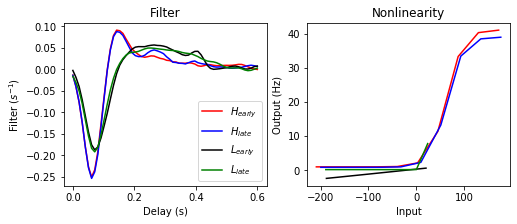

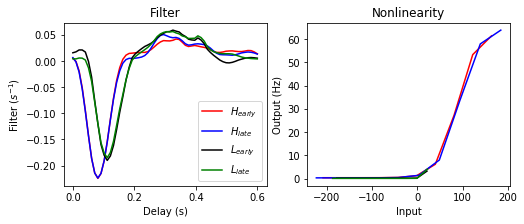

In [418]:
c0=0.05
c1=0.35
nrepeats=100
stimuli, responses = contrast_adaptation_LN(model, device, c0=c0, c1=c1, nrepeats=nrepeats, scale=4.46, fpf=3, **data_kwargs)

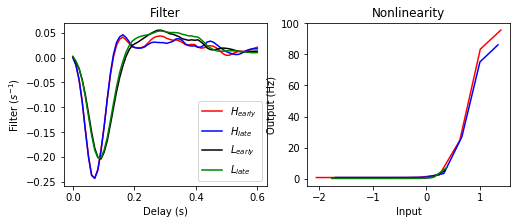

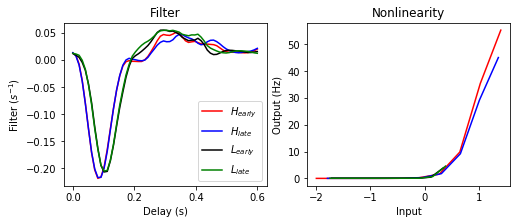

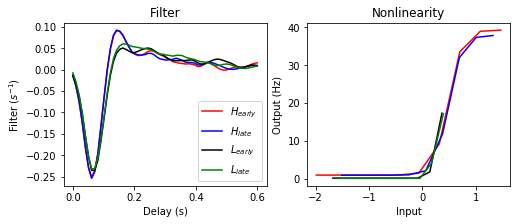

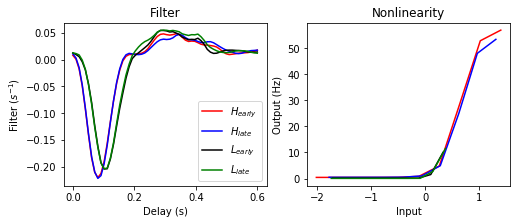

In [430]:
with open('/home/xhding/workspaces/torch-deep-retina/kinetic/notebook/stimuli/epoch_045_loss_-60.35_pearson_natural_0.4354_pearson_noise_0.4798.npy', 'rb') as f:
    stimuli = np.load(f)
    stimuli = [stim for stim in stimuli]
ratio = 2/3
new_stimuli = []
for stimulus in stimuli:
    stimulus = np.repeat(stimulus[::3], 3, axis=0)
    new_stim = np.concatenate((stimulus[:1000] * ratio, stimulus[1000:2000], stimulus[2000:] * ratio), axis=0)
    new_stimuli.append(new_stim)
c0=0.1
c1=0.35
nrepeats=100
stimuli, responses = contrast_adaptation_LN(model, device, c0=c0, c1=c1, nrepeats=nrepeats, scale=4.46, fpf=3, load_stimuli=new_stimuli, **data_kwargs)

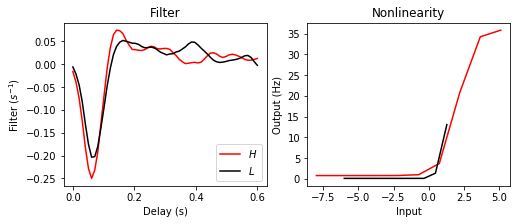

In [424]:
sta_h, x_h, nonlinear_h = LN_model_multi_trials(stimuli, responses, contrast=0.35, cell=2, start_idx=1000, end_idx=2000, filter_len=100, sta_type='revcor')
sta_l, x_l, nonlinear_l = LN_model_multi_trials(stimuli, responses, contrast=0.1, cell=2, start_idx=2000, end_idx=3000, filter_len=100, sta_type='revcor')

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].plot(np.linspace(0, 0.6, 60), sta_h[:60], 'r', label=r'$H$')
axes[0].plot(np.linspace(0, 0.6, 60), sta_l[:60], 'k', label=r'$L$')
axes[0].legend()
axes[0].set_xlabel('Delay (s)')
axes[0].set_ylabel(r'Filter ($s^{-1}$)')
axes[0].set_title('Filter')


axes[1].plot(x_h, nonlinear_h, 'r', label=r'$H$')
axes[1].plot(x_l, nonlinear_l, 'k', label=r'$L$')
axes[1].set_xlabel('Input')
axes[1].set_ylabel('Output (Hz)')
axes[1].set_title('Nonlinearity')

plt.show()

In [440]:
c1 = 0.35
c0 = 0.15
nrepeats = 10
envelope = c1 * np.ones((4000, 1, 1))
envelope[2000:4000] = c0
envelope = np.concatenate([envelope for _ in range(nrepeats)])
stimulus = random_from_envelope(envelope, repeat=3)
stimulus = 4.46 * stimulus
stimulus_rolling = stim.concat(stimulus, nh=40)
hs = get_hs(model, 1, device, None, 'single')
val_pred = []
with torch.no_grad():
    for idx in range(stimulus_rolling.shape[0]):
        x = torch.from_numpy(stimulus_rolling[idx:idx+1]).to(device)
        out, hs = model(x, hs)
        val_pred.append(out.detach().cpu().numpy().squeeze(0))
    val_pred = np.stack(val_pred, axis=0)

In [441]:
responses = val_pred[3960:, :].reshape((9, -1, 4))
responses = [resp for resp in responses]
stimuli = stimulus.squeeze().reshape(10, -1)[1:]
stimuli = [stim+4.46 for stim in stimuli]

sta_h, x_h, nonlinear_h = LN_model_multi_trials(stimuli, responses, contrast=0.35, cell=2, start_idx=0, end_idx=2000, filter_len=100, sta_type='revcor')
sta_l, x_l, nonlinear_l = LN_model_multi_trials(stimuli, responses, contrast=0.15, cell=2, start_idx=2000, end_idx=4000, filter_len=100, sta_type='revcor')

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].plot(np.linspace(0, 0.6, 60), sta_h[:60], 'r', label=r'$H$')
axes[0].plot(np.linspace(0, 0.6, 60), sta_l[:60], 'k', label=r'$L$')
axes[0].legend()
axes[0].set_xlabel('Delay (s)')
axes[0].set_ylabel(r'Filter ($s^{-1}$)')
axes[0].set_title('Filter')


axes[1].plot(x_h, nonlinear_h, 'r', label=r'$H$')
axes[1].plot(x_l, nonlinear_l, 'k', label=r'$L$')
axes[1].set_xlabel('Input')
axes[1].set_ylabel('Output (Hz)')
axes[1].set_title('Nonlinearity')

plt.show()

ValueError: `stimulus` and `response` must match in size along the first axis

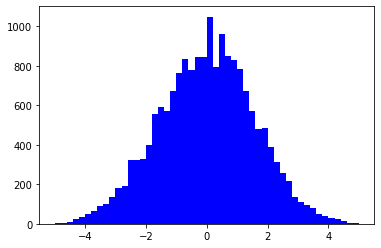

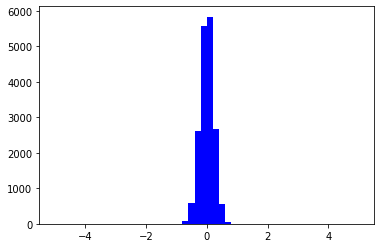

In [389]:
a = []
for stimulus in stimuli:
    a.append(stimulus[:2000])
plt.hist(np.concatenate(a), bins=50, color='blue', range=(-5,5))
plt.show()
a = []
for stimulus in stimuli:
    a.append(stimulus[2000:])
plt.hist(np.concatenate(a), bins=50, color='blue', range=(-5,5))
plt.show()

In [408]:
with h5py.File('/home/xhding/tem_stim/21-01-26/fullfield.h5', 'r') as f:
    stimulus =  np.asarray(f['train']['stimulus']).astype('float32')
stimulus = (stimulus - 127.5)/28.6
stimulus_rolling = stim.concat(stimulus, nh=40)
hs = get_hs(model, 1, device, None, 'single')
val_pred = []
with torch.no_grad():
    for idx in range(stimulus_rolling.shape[0]):
        x = torch.from_numpy(stimulus_rolling[idx:idx+1]).to(device)
        out, hs = model(x, hs)
        val_pred.append(out.detach().cpu().numpy().squeeze(0))
    val_pred = np.stack(val_pred, axis=0)

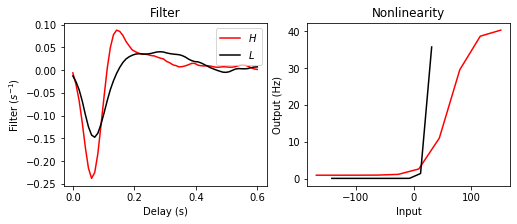

In [409]:
responses = val_pred[3966:40020, :].reshape((9, -1, 4))
responses = [resp for resp in responses]
stimuli = stimulus[:40060,25,25].reshape(10, -1)[1:]
stimuli = [stim*28.6+127.5 for stim in stimuli]

sta_h, x_h, nonlinear_h = LN_model_multi_trials(stimuli, responses, contrast=0.35, cell=2, start_idx=0, end_idx=2000, filter_len=100, sta_type='revcor')
sta_l, x_l, nonlinear_l = LN_model_multi_trials(stimuli, responses, contrast=0.05, cell=2, start_idx=2000, end_idx=4000, filter_len=100, sta_type='revcor')

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].plot(np.linspace(0, 0.6, 60), sta_h[:60], 'r', label=r'$H$')
axes[0].plot(np.linspace(0, 0.6, 60), sta_l[:60], 'k', label=r'$L$')
axes[0].legend()
axes[0].set_xlabel('Delay (s)')
axes[0].set_ylabel(r'Filter ($s^{-1}$)')
axes[0].set_title('Filter')


axes[1].plot(x_h, nonlinear_h, 'r', label=r'$H$')
axes[1].plot(x_l, nonlinear_l, 'k', label=r'$L$')
axes[1].set_xlabel('Input')
axes[1].set_ylabel('Output (Hz)')
axes[1].set_title('Nonlinearity')

plt.show()

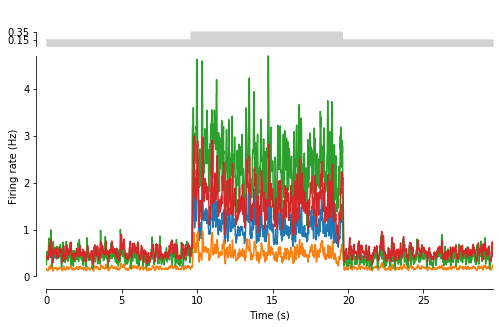

In [190]:
figs, layer_outs = contrast_adaptation_kinetic(model, device, ['kinetics'], scale=4.46, c0=0.15, c1=0.35, nrepeats=100, stimuli=stimuli)

In [188]:
with open('/home/xhding/workspaces/torch-deep-retina/kinetic/notebook/stimuli/epoch_045_loss_-60.35_pearson_natural_0.4354_pearson_noise_0.4798.npy', 'wb') as f:
    np.save(f, np.array(stimuli))
    f.close()

In [231]:
n_units = 4
data_kwargs = dict(cfg.Data)

data_kwargs['stim'] = 'fullfield_whitenoise'
cfg.Data.start_idx = 4000
train_dataset_noise = MyDataset(stim_sec='train', **data_kwargs)
test_data_noise =  DataLoader(dataset=MyDataset(stim_sec='test', stats=train_dataset_noise.stats, **data_kwargs))
test_pc_noise = pearsonr_eval(model, test_data_noise, n_units, device, I20=cfg.Data.I20, start_idx=cfg.Data.start_idx, hs_mode=cfg.Data.hs_mode)

cfg.Data.start_idx = 0
data_kwargs['stim'] = 'naturalscene'
train_dataset_natural = MyDataset(stim_sec='train', **data_kwargs)
test_data_natural =  DataLoader(dataset=MyDataset(stim_sec='test', stats=train_dataset_natural.stats, **data_kwargs))
test_pc_natural = pearsonr_eval(model, test_data_natural, n_units, device,
                                I20=cfg.Data.I20, start_idx=cfg.Data.start_idx, hs_mode=cfg.Data.hs_mode)

print(test_pc_noise, test_pc_natural)

0.6527597687265423 0.5778606221103997


In [238]:
n_units = 4
data_kwargs = dict(cfg.Data)

data_kwargs['stim'] = 'fullfield_whitenoise'
cfg.Data.start_idx = 4000
train_dataset_noise = MyDataset(stim_sec='train', **data_kwargs)
test_data_noise =  DataLoader(dataset=MyDataset(stim_sec='test', stats=train_dataset_noise.stats, **data_kwargs), shuffle=True)
test_pc_noise = pearsonr_eval(model, test_data_noise, n_units, device, I20=cfg.Data.I20, start_idx=cfg.Data.start_idx, hs_mode=cfg.Data.hs_mode)

cfg.Data.start_idx = 0
data_kwargs['stim'] = 'naturalscene'
train_dataset_natural = MyDataset(stim_sec='train', **data_kwargs)
test_data_natural =  DataLoader(dataset=MyDataset(stim_sec='test', stats=train_dataset_natural.stats, **data_kwargs), shuffle=True)
test_pc_natural = pearsonr_eval(model, test_data_natural, n_units, device,
                                I20=cfg.Data.I20, start_idx=cfg.Data.start_idx, hs_mode=cfg.Data.hs_mode)

print(test_pc_noise, test_pc_natural)

0.37987617711763016 0.45018564844367637


In [239]:
model.kinetics.ksr.data = torch.tensor([[0.]]).to(device)
model.kinetics.ksi.data = torch.tensor([[0.]]).to(device)

In [240]:
n_units = 4
data_kwargs = dict(cfg.Data)


data_kwargs['stim'] = 'fullfield_whitenoise'
cfg.Data.start_idx = 4000
train_dataset_noise = MyDataset(stim_sec='train', **data_kwargs)
test_data_noise =  DataLoader(dataset=MyDataset(stim_sec='test', stats=train_dataset_noise.stats, **data_kwargs))
test_pc_noise = pearsonr_eval(model, test_data_noise, n_units, device, I20=cfg.Data.I20, start_idx=cfg.Data.start_idx, hs_mode=cfg.Data.hs_mode)

cfg.Data.start_idx = 0
data_kwargs['stim'] = 'naturalscene'
train_dataset_natural = MyDataset(stim_sec='train', **data_kwargs)
test_data_natural =  DataLoader(dataset=MyDataset(stim_sec='test', stats=train_dataset_natural.stats, **data_kwargs))
test_pc_natural = pearsonr_eval(model, test_data_natural, n_units, device,
                                I20=cfg.Data.I20, start_idx=cfg.Data.start_idx, hs_mode=cfg.Data.hs_mode)

print(test_pc_noise, test_pc_natural)

0.658786953473982 0.576772615619508


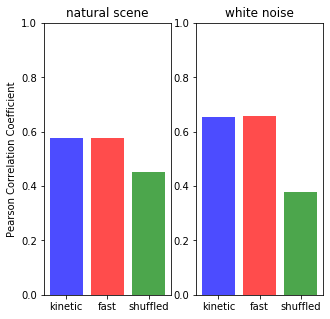

In [247]:
fig, axes = plt.subplots(1,2, figsize=(5,5))

rects1 = axes[0].bar(['kinetic', 'fast', 'shuffled'], [0.578, 0.577, 0.450], color=['blue', 'red', 'green'], alpha=0.7)
axes[0].set_ylabel('Pearson Correlation Coefficient')
axes[0].set_ylim([0, 1])
axes[0].set_title('natural scene')

rects1 = axes[1].bar(['kinetic', 'fast', 'shuffled'], [0.653, 0.659, 0.380], color=['blue', 'red', 'green'], alpha=0.7)
axes[1].set_ylim([0, 1])
axes[1].set_title('white noise')

plt.savefig('/home/xhding/workspaces/torch-deep-retina/kinetic/notebook/figures/pearson.png', dpi=300,  bbox_inches = "tight")

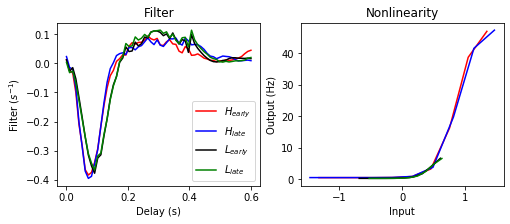

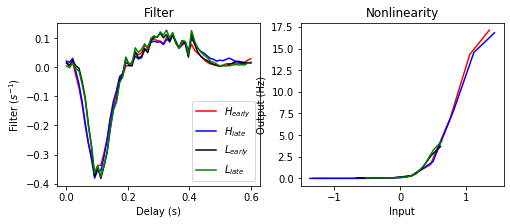

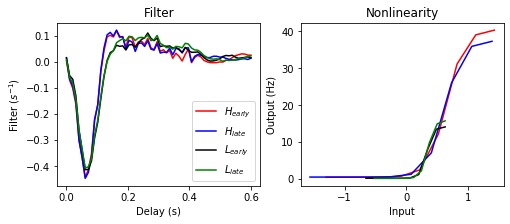

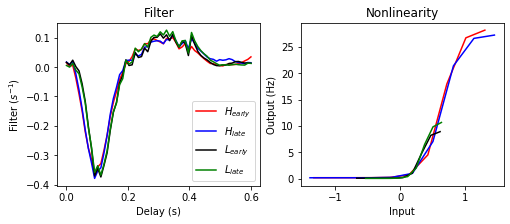

In [250]:
c0=0.15
c1=0.35
nrepeats=100
stimuli, responses = contrast_adaptation_LN(model, device, c0=c0, c1=c1, nrepeats=nrepeats, scale=4.46, stimuli=stimuli, **data_kwargs)

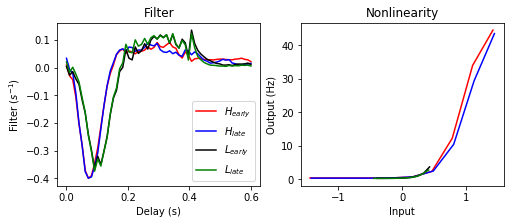

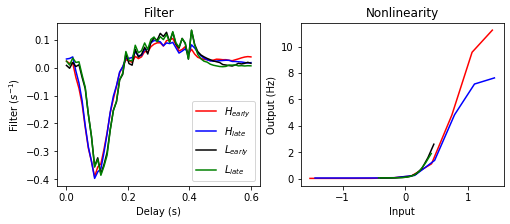

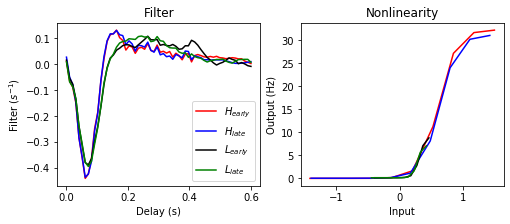

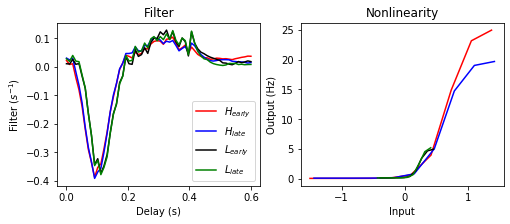

In [290]:
ratio = 2/3
new_stimuli = []
for stimulus in stimuli:
    new_stim = np.concatenate((stimulus[:1000] * ratio, stimulus[1000:2000], stimulus[2000:] * ratio), axis=0)
    new_stimuli.append(new_stim)
c0=0.10
c1=0.35
nrepeats=100
stimuli, responses = contrast_adaptation_LN(model, device, c0=c0, c1=c1, nrepeats=nrepeats, scale=4.46, fpf=1, loaded_stimuli=new_stimuli, **data_kwargs)

In [431]:
device = torch.device('cuda:2')
checkpoint_path = '/home/xhding/archived_models/20-09-15/kinetics/full.pth'
checkpoint_path_one_pixel = '/home/xhding/archived_models/20-09-15/kinetics/one_pixel.pth'
cfg_name = 'kinetics_both'

cfg = get_custom_cfg(cfg_name)
cfg.Model.n_units = 3
checkpoint = torch.load(checkpoint_path, map_location=device)
model_func = getattr(models, cfg.Model.name)
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

if checkpoint_path_one_pixel != '':
    checkpoint_one_pixel = torch.load(checkpoint_path_one_pixel, map_location=device)
    model.kinetics.ksi.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksi']
    model.kinetics.ksr.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr']
    try:
        if model.ksr_gain:
            model.kinetics.ksr_2.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr_2']
    except:
        pass

model.eval()

data_kwargs = dict(cfg.Data)

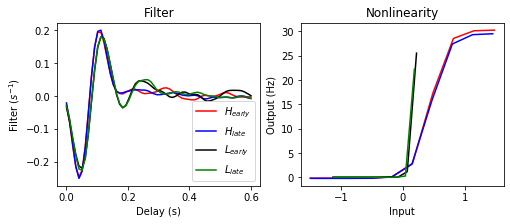

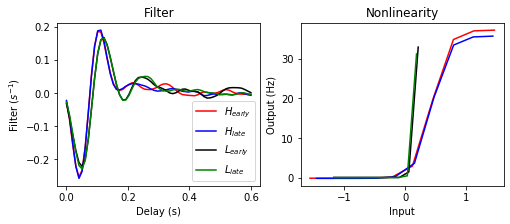

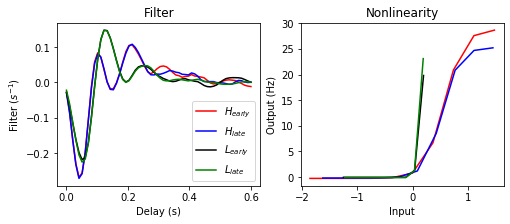

In [432]:
c0=0.05
c1=0.35
nrepeats=100
stimuli, responses = contrast_adaptation_LN(model, device, c0=c0, c1=c1, nrepeats=nrepeats, scale=4.46, fpf=3, **data_kwargs)

In [433]:
c1 = 0.35
c0 = 0.05
nrepeats = 10
envelope = c1 * np.ones((4000, 1, 1))
envelope[2000:4000] = c0
envelope = np.concatenate([envelope for _ in range(nrepeats)])
stimulus = random_from_envelope(envelope, repeat=3)
stimulus = 4.46 * stimulus
stimulus_rolling = stim.concat(stimulus, nh=40)
hs = get_hs(model, 1, device, None, 'single')
val_pred = []
with torch.no_grad():
    for idx in range(stimulus_rolling.shape[0]):
        x = torch.from_numpy(stimulus_rolling[idx:idx+1]).to(device)
        out, hs = model(x, hs)
        val_pred.append(out.detach().cpu().numpy().squeeze(0))
    val_pred = np.stack(val_pred, axis=0)

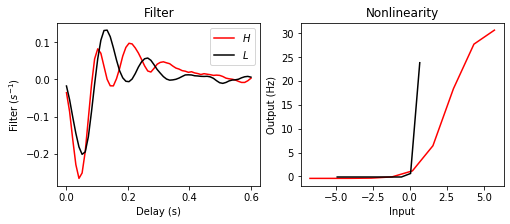

In [439]:
responses = val_pred[3960:, :].reshape((9, -1, 3))
responses = [resp for resp in responses]
stimuli = stimulus.squeeze().reshape(10, -1)[1:]
stimuli = [stim+4.46 for stim in stimuli]

sta_h, x_h, nonlinear_h = LN_model_multi_trials(stimuli, responses, contrast=0.35, cell=2, start_idx=0, end_idx=2000, filter_len=100, sta_type='revcor')
sta_l, x_l, nonlinear_l = LN_model_multi_trials(stimuli, responses, contrast=0.05, cell=2, start_idx=2000, end_idx=4000, filter_len=100, sta_type='revcor')

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].plot(np.linspace(0, 0.6, 60), sta_h[:60], 'r', label=r'$H$')
axes[0].plot(np.linspace(0, 0.6, 60), sta_l[:60], 'k', label=r'$L$')
axes[0].legend()
axes[0].set_xlabel('Delay (s)')
axes[0].set_ylabel(r'Filter ($s^{-1}$)')
axes[0].set_title('Filter')


axes[1].plot(x_h, nonlinear_h, 'r', label=r'$H$')
axes[1].plot(x_l, nonlinear_l, 'k', label=r'$L$')
axes[1].set_xlabel('Input')
axes[1].set_ylabel('Output (Hz)')
axes[1].set_title('Nonlinearity')

plt.show()

In [438]:
responses[0].shape

(3000, 4)

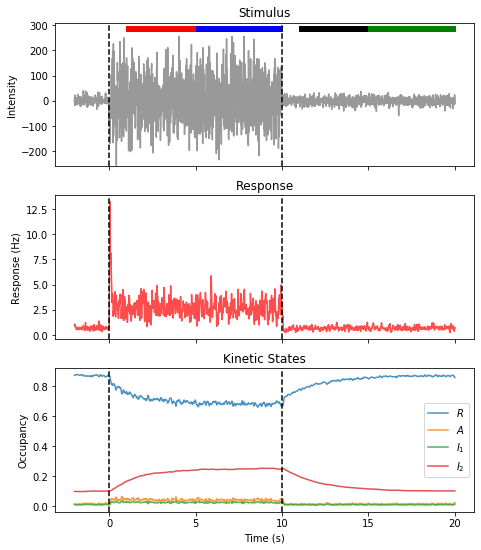

In [276]:
fig, axes = plt.subplots(3,1, figsize=(7.5,9), sharex=True)
for trial in range(len(stimuli)):
    stimuli[trial][stimuli[trial]>1.] = 1.
    stimuli[trial][stimuli[trial]<-1.] = -1.
axes[0].plot(np.linspace(-2, 20, 2200), 255*stimuli[0][800:], color='gray', alpha=0.8)
axes[0].axvline(x=0, color='black', ls='--')
axes[0].axvline(x=10, color='black', ls='--')
axes[0].set_ylabel('Intensity')
axes[0].set_title('Stimulus')
axes[0].set_ylim((-260, 310))
axes[0].add_patch(patches.Rectangle((1, 275), 4, 20, color='red'))
axes[0].add_patch(patches.Rectangle((5, 275), 5, 20, color='blue'))
axes[0].add_patch(patches.Rectangle((11, 275), 4, 20, color='black'))
axes[0].add_patch(patches.Rectangle((15, 275), 5, 20, color='green'))

axes[1].plot(np.linspace(-2, 20, 2200), np.array(responses).mean(0)[800:, 2], color='r', alpha=0.7)
axes[1].axvline(x=0, color='black', ls='--')
axes[1].axvline(x=10, color='black', ls='--')
axes[1].set_ylabel('Response (Hz)')
axes[1].set_title('Response')

channel = 1
axes[2].plot(np.linspace(-2, 20, 2200),layer_outs['kinetics'][760:, 0, channel], label=r'$R$', alpha=0.8)
axes[2].plot(np.linspace(-2, 20, 2200),layer_outs['kinetics'][760:, 1, channel], label=r'$A$', alpha=0.8)
axes[2].plot(np.linspace(-2, 20, 2200),layer_outs['kinetics'][760:, 2, channel], label=r'$I_1$', alpha=0.8)
axes[2].plot(np.linspace(-2, 20, 2200),layer_outs['kinetics'][760:, 3, channel], label=r'$I_2$', alpha=0.8)
axes[2].legend()
axes[2].axvline(x=0, color='black', ls='--')
axes[2].axvline(x=10, color='black', ls='--')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Occupancy')
axes[2].set_title('Kinetic States')

plt.savefig('/home/xhding/workspaces/torch-deep-retina/kinetic/notebook/figures/response.png', dpi=300,  bbox_inches = "tight")

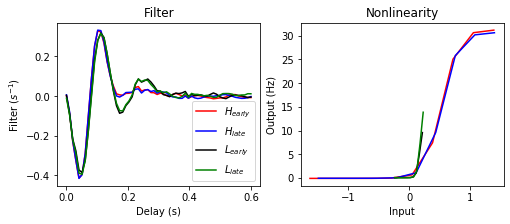

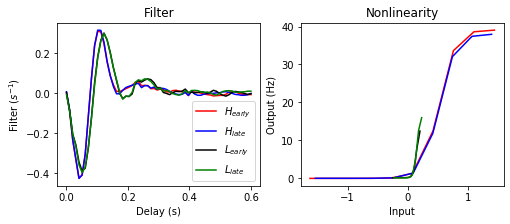

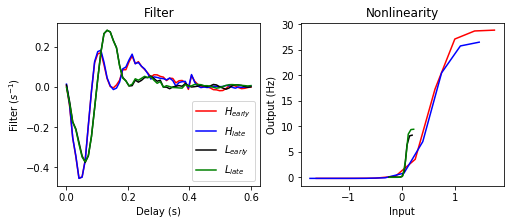

In [278]:
c0=0.05
c1=0.35
nrepeats=200
stimuli, responses = contrast_adaptation_LN(model, device, c0=c0, c1=c1, nrepeats=nrepeats, scale=4.46, **data_kwargs)

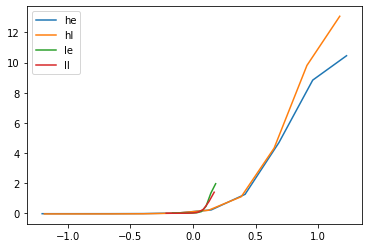

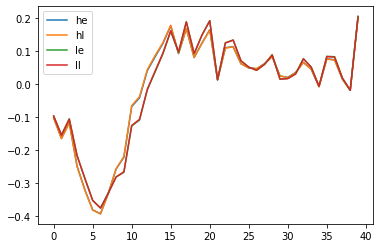

In [284]:
filters, nonlinear = gradient_LN(model, device, cell = 2, c0 = 0.05, c1 = 0.35, scale=4.46, shift=0., fpf=1, stim_type='checkerboard', nrepeats=10)

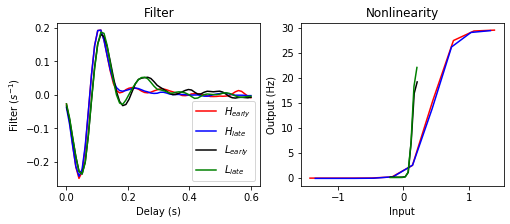

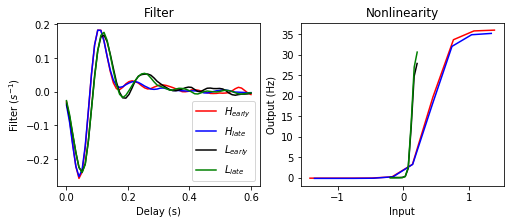

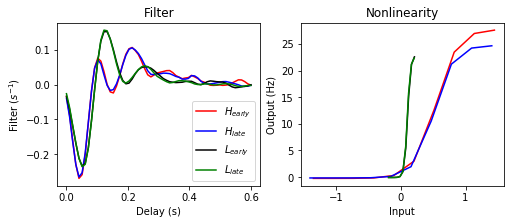

In [285]:
c0=0.05
c1=0.35
nrepeats=100
stimuli, responses = contrast_adaptation_LN(model, device, c0=c0, c1=c1, nrepeats=nrepeats, scale=4.46, fpf=3, **data_kwargs)

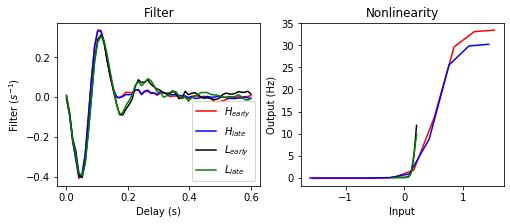

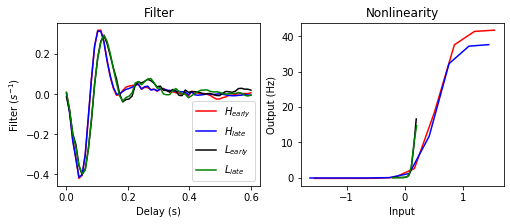

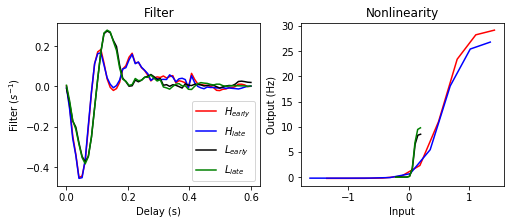

In [287]:
ratio = 1/3
new_stimuli = []
for stimulus in stimuli:
    new_stim = np.concatenate((stimulus[:1000] * ratio, stimulus[1000:2000], stimulus[2000:] * ratio), axis=0)
    new_stimuli.append(new_stim)
c0=0.05
c1=0.35
nrepeats=100
stimuli, responses = contrast_adaptation_LN(model, device, c0=c0, c1=c1, nrepeats=nrepeats, scale=4.46, fpf=1, loaded_stimuli=new_stimuli, **data_kwargs)

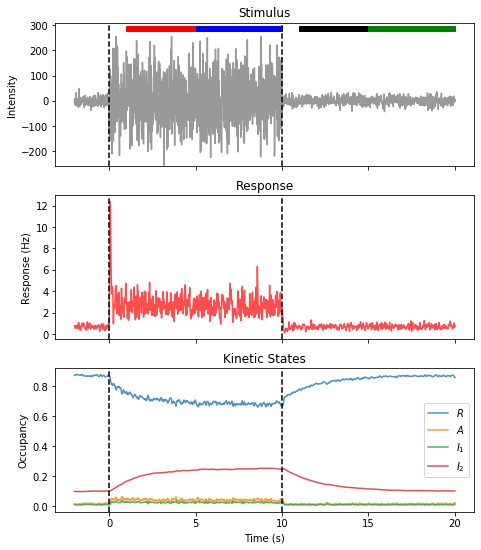

In [288]:
fig, axes = plt.subplots(3,1, figsize=(7.5,9), sharex=True)
for trial in range(len(stimuli)):
    stimuli[trial][stimuli[trial]>1.] = 1.
    stimuli[trial][stimuli[trial]<-1.] = -1.
axes[0].plot(np.linspace(-2, 20, 2200), 255*stimuli[0][800:], color='gray', alpha=0.8)
axes[0].axvline(x=0, color='black', ls='--')
axes[0].axvline(x=10, color='black', ls='--')
axes[0].set_ylabel('Intensity')
axes[0].set_title('Stimulus')
axes[0].set_ylim((-260, 310))
axes[0].add_patch(patches.Rectangle((1, 275), 4, 20, color='red'))
axes[0].add_patch(patches.Rectangle((5, 275), 5, 20, color='blue'))
axes[0].add_patch(patches.Rectangle((11, 275), 4, 20, color='black'))
axes[0].add_patch(patches.Rectangle((15, 275), 5, 20, color='green'))

axes[1].plot(np.linspace(-2, 20, 2200), np.array(responses).mean(0)[800:, 2], color='r', alpha=0.7)
axes[1].axvline(x=0, color='black', ls='--')
axes[1].axvline(x=10, color='black', ls='--')
axes[1].set_ylabel('Response (Hz)')
axes[1].set_title('Response')

channel = 1
axes[2].plot(np.linspace(-2, 20, 2200),layer_outs['kinetics'][760:, 0, channel], label=r'$R$', alpha=0.8)
axes[2].plot(np.linspace(-2, 20, 2200),layer_outs['kinetics'][760:, 1, channel], label=r'$A$', alpha=0.8)
axes[2].plot(np.linspace(-2, 20, 2200),layer_outs['kinetics'][760:, 2, channel], label=r'$I_1$', alpha=0.8)
axes[2].plot(np.linspace(-2, 20, 2200),layer_outs['kinetics'][760:, 3, channel], label=r'$I_2$', alpha=0.8)
axes[2].legend()
axes[2].axvline(x=0, color='black', ls='--')
axes[2].axvline(x=10, color='black', ls='--')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Occupancy')
axes[2].set_title('Kinetic States')

plt.savefig('/home/xhding/workspaces/torch-deep-retina/kinetic/notebook/figures/response.png', dpi=300,  bbox_inches = "tight")

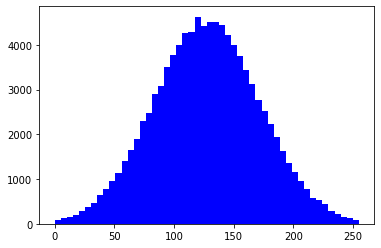

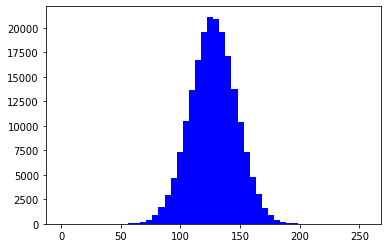

In [304]:
a = []
for stimulus in stimuli:
    a.append(4.46*stimulus[1000:2000]*28.6+127.5)
plt.hist(np.concatenate(a), bins=50, color='blue', range=(0,255))
plt.show()
a = []
for stimulus in stimuli:
    a.append(4.46*stimulus[:1000]*28.6+127.5)
    a.append(4.46*stimulus[2000:]*28.6+127.5)
plt.hist(np.concatenate(a), bins=50, color='blue', range=(0,255))
plt.show()

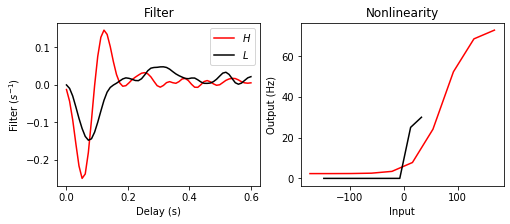

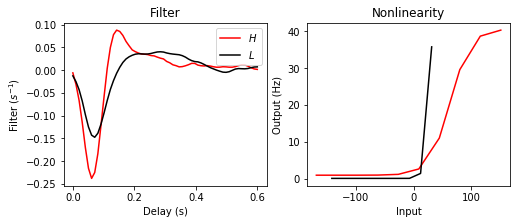

In [407]:
with h5py.File('/home/xhding/tem_stim/21-01-26/fullfield.h5', 'r') as f:
    stimulus =  np.asarray(f['train']['stimulus'][:, 25, 25]).astype('float32')
    resp = np.asarray(f['train']['response']['firing_rate_10ms'])
stimuli = stimulus[:40060].reshape((10,-1))
responses = np.swapaxes(resp, 0, 1)[:40060].reshape((10, -1, 11))
stimuli = [stim for stim in stimuli]
responses = [resp for resp in responses]

sta_h, x_h, nonlinear_h = LN_model_multi_trials(stimuli, responses, contrast=0.35, cell=7, start_idx=0, end_idx=2000, filter_len=100, sta_type='revcor')
sta_l, x_l, nonlinear_l = LN_model_multi_trials(stimuli, responses, contrast=0.05, cell=7, start_idx=2000, end_idx=4000, filter_len=100, sta_type='revcor')

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].plot(np.linspace(0, 0.6, 60), sta_h[:60], 'r', label=r'$H$')
axes[0].plot(np.linspace(0, 0.6, 60), sta_l[:60], 'k', label=r'$L$')
axes[0].legend()
axes[0].set_xlabel('Delay (s)')
axes[0].set_ylabel(r'Filter ($s^{-1}$)')
axes[0].set_title('Filter')


axes[1].plot(x_h, nonlinear_h, 'r', label=r'$H$')
axes[1].plot(x_l, nonlinear_l, 'k', label=r'$L$')
axes[1].set_xlabel('Input')
axes[1].set_ylabel('Output (Hz)')
axes[1].set_title('Nonlinearity')

plt.show()

responses = val_pred[3966:40020, :].reshape((9, -1, 4))
responses = [resp for resp in responses]
stimuli = stimuli[1:]

sta_h, x_h, nonlinear_h = LN_model_multi_trials(stimuli, responses, contrast=0.35, cell=2, start_idx=0, end_idx=2000, filter_len=100, sta_type='revcor')
sta_l, x_l, nonlinear_l = LN_model_multi_trials(stimuli, responses, contrast=0.05, cell=2, start_idx=2000, end_idx=4000, filter_len=100, sta_type='revcor')

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].plot(np.linspace(0, 0.6, 60), sta_h[:60], 'r', label=r'$H$')
axes[0].plot(np.linspace(0, 0.6, 60), sta_l[:60], 'k', label=r'$L$')
axes[0].legend()
axes[0].set_xlabel('Delay (s)')
axes[0].set_ylabel(r'Filter ($s^{-1}$)')
axes[0].set_title('Filter')


axes[1].plot(x_h, nonlinear_h, 'r', label=r'$H$')
axes[1].plot(x_l, nonlinear_l, 'k', label=r'$L$')
axes[1].set_xlabel('Input')
axes[1].set_ylabel('Output (Hz)')
axes[1].set_title('Nonlinearity')

plt.show()

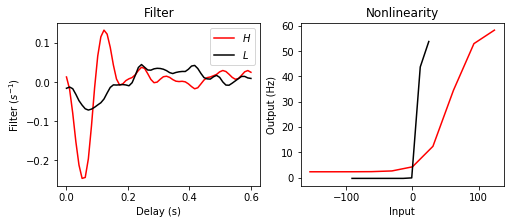

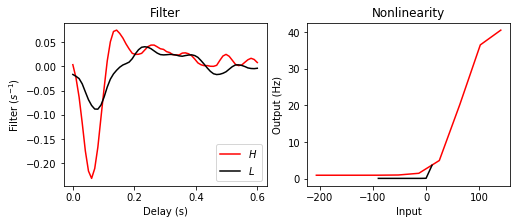

In [337]:
with h5py.File('/home/xhding/tem_stim/21-01-26/fullfield.h5', 'r') as f:
    stimulus =  np.asarray(f['train']['stimulus'][:, 25, 25]).astype('float32')
    resp = np.asarray(f['train']['response']['firing_rate_10ms'])
stimuli = stimulus[:40060].reshape((10,-1))
responses = np.swapaxes(resp, 0, 1)[:40060].reshape((10, -1, 11))
stimuli = [stim for stim in stimuli]
responses = [resp for resp in responses]

sta_h, x_h, nonlinear_h = LN_model_multi_trials(stimuli, responses, contrast=0.35, cell=7, start_idx=1500, end_idx=2000, filter_len=100, sta_type='revcor')
sta_l, x_l, nonlinear_l = LN_model_multi_trials(stimuli, responses, contrast=0.05, cell=7, start_idx=3500, end_idx=4000, filter_len=100, sta_type='revcor')

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].plot(np.linspace(0, 0.6, 60), sta_h[:60], 'r', label=r'$H$')
axes[0].plot(np.linspace(0, 0.6, 60), sta_l[:60], 'k', label=r'$L$')
axes[0].legend()
axes[0].set_xlabel('Delay (s)')
axes[0].set_ylabel(r'Filter ($s^{-1}$)')
axes[0].set_title('Filter')


axes[1].plot(x_h, nonlinear_h, 'r', label=r'$H$')
axes[1].plot(x_l, nonlinear_l, 'k', label=r'$L$')
axes[1].set_xlabel('Input')
axes[1].set_ylabel('Output (Hz)')
axes[1].set_title('Nonlinearity')

plt.show()

responses = val_pred[3966:40020, :].reshape((9, -1, 4))
responses = [resp for resp in responses]
stimuli = stimuli[1:]

sta_h, x_h, nonlinear_h = LN_model_multi_trials(stimuli, responses, contrast=0.35, cell=2, start_idx=1500, end_idx=2000, filter_len=100, sta_type='revcor')
sta_l, x_l, nonlinear_l = LN_model_multi_trials(stimuli, responses, contrast=0.05, cell=2, start_idx=3500, end_idx=4000, filter_len=100, sta_type='revcor')

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].plot(np.linspace(0, 0.6, 60), sta_h[:60], 'r', label=r'$H$')
axes[0].plot(np.linspace(0, 0.6, 60), sta_l[:60], 'k', label=r'$L$')
axes[0].legend()
axes[0].set_xlabel('Delay (s)')
axes[0].set_ylabel(r'Filter ($s^{-1}$)')
axes[0].set_title('Filter')


axes[1].plot(x_h, nonlinear_h, 'r', label=r'$H$')
axes[1].plot(x_l, nonlinear_l, 'k', label=r'$L$')
axes[1].set_xlabel('Input')
axes[1].set_ylabel('Output (Hz)')
axes[1].set_title('Nonlinearity')

plt.show()

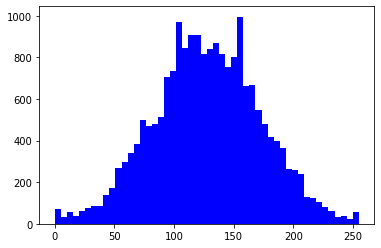

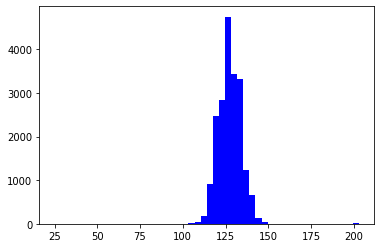

In [390]:
with h5py.File('/home/xhding/tem_stim/21-01-26/fullfield.h5', 'r') as f:
    stimulus =  np.asarray(f['train']['stimulus'][:, 25, 25]).astype('float32')
    resp = np.asarray(f['train']['response']['firing_rate_10ms'])
stimuli = stimulus[:40060].reshape((10,-1))
stimuli = [stim for stim in stimuli]

a = []
for stimulus in stimuli:
    a.append(stimulus[:2000])
plt.hist(np.concatenate(a), bins=50, color='blue')
plt.show()
a = []
for stimulus in stimuli:
    a.append(stimulus[2000:])
plt.hist(np.concatenate(a), bins=50, color='blue')
plt.show()

In [442]:
checkpoint_path = '/home/xhding/saved_model/kinetics_both/epoch_045_loss_-62.71_pearson_natural_0.4564_pearson_noise_0.4508.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)

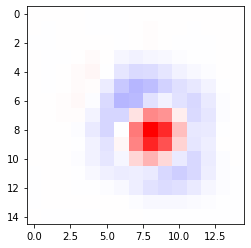

In [463]:
state_dict = checkpoint['model_state_dict']
conv_weights = []
for i in range((cfg.Model.ksizes[0]-1)//2):
    conv_weights.append(state_dict['bipolar.0.convs.{}.weight'.format(i)].cpu().numpy())
#kernel = LinearStack(conv_weights)[0, 10]
kernel = pyret.filtertools.decompose(LinearStack(conv_weights)[6])[0]
plt.imshow(kernel, cmap='bwr', vmin=-np.abs(kernel).max(), vmax=np.abs(kernel).max())

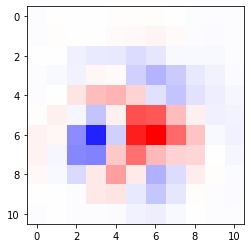

In [474]:
state_dict = checkpoint['model_state_dict']
conv_weights = []
for i in range((cfg.Model.ksizes[1]-1)//2):
    conv_weights.append(state_dict['amacrine.1.convs.{}.weight'.format(i)].cpu().numpy())
kernel = pyret.filtertools.decompose(LinearStack(conv_weights)[3])[0]
plt.imshow(kernel, cmap='bwr', vmin=-np.abs(kernel).max(), vmax=np.abs(kernel).max())

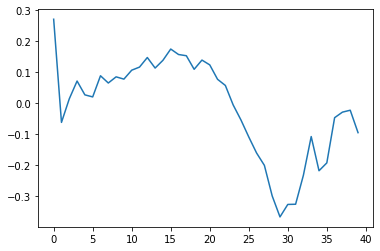

In [479]:
state_dict = checkpoint['model_state_dict']
conv_weights = []
for i in range((cfg.Model.ksizes[0]-1)//2):
    conv_weights.append(state_dict['bipolar.0.convs.{}.weight'.format(i)].cpu().numpy())
#kernel = LinearStack(conv_weights)[0, 10]
kernel = pyret.filtertools.decompose(LinearStack(conv_weights)[6])[1]
plt.plot(kernel)

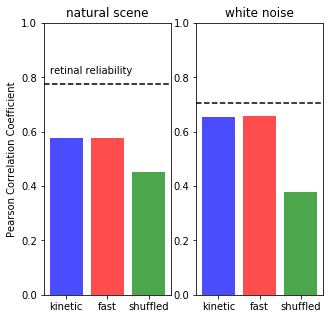

In [494]:
fig, axes = plt.subplots(1,2, figsize=(5,5))

rects1 = axes[0].bar(['kinetic', 'fast', 'shuffled'], [0.578, 0.577, 0.450], color=['blue', 'red', 'green'], alpha=0.7)
axes[0].axhline(y=0.775, linestyle='--', color='black')
axes[0].annotate("retinal reliability", (50,245), xycoords='figure pixels')
axes[0].set_ylabel('Pearson Correlation Coefficient')
axes[0].set_ylim([0, 1])
axes[0].set_title('natural scene')

rects1 = axes[1].bar(['kinetic', 'fast', 'shuffled'], [0.653, 0.659, 0.380], color=['blue', 'red', 'green'], alpha=0.7)
axes[1].axhline(y=0.704, linestyle='--', color='black')
axes[1].set_ylim([0, 1])
axes[1].set_title('white noise')

plt.savefig('/home/xhding/workspaces/torch-deep-retina/kinetic/notebook/figures/pearson.png', dpi=300,  bbox_inches = "tight")

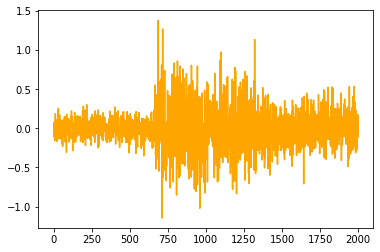

In [497]:
envelope = np.ones((2000))*0.35
envelope[:666] = 0.1
envelope[1332:] = 0.2
noise = np.random.randn(*envelope.shape) * envelope
plt.plot(noise, color='orange')